**Распределение по выполненной работе:**


*   EDA, Feature Engineering, Catboost - Попова Диана
*   Bert4Rec, ALS, Baseline Models - Тихомиров Степан



## Results

В рамках соревнования по курсу построили разные модели рекомендательных систем для пользователей онлайн-кинотеатра.

Значительно превзошла Baseline модель Bert4Rec, продемонстрировав Recall@10 равным 0.1703. За ней - простая, но гордая ALS, аккуратный тюнинг которой позволил добиться 0.075 на итоговых данных. Самой низкой по качеству оказалась модель CatBoost, показав значение полноты на тесте равным 0.0299, что вероятно связано с недостаточным количеством признаков для обучения и необходимостью использования признаков ALS-модели на вход. Базовые подходы с поиском самых популярных фильмов по просмотрам и рейтингам использовались не отдельно, а в качестве кандидатов для рекомендаций внутри ALS-модели.

## Подготовка к работе: импорт данных и библиотек

In [ ]:
!pip install lightning -q
!pip install replay-rec -q

In [ ]:
!pip install rs-datasets

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
tqdm.pandas()

In [ ]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import torch

from replay.metrics import OfflineMetrics, Recall, Precision, MAP, NDCG, HitRate, MRR
from replay.metrics.torch_metrics_builder import metrics_to_df
from replay.splitters import LastNSplitter
from replay.utils import get_spark_session
from replay.data import (
    FeatureHint,
    FeatureInfo,
    FeatureSchema,
    FeatureSource,
    FeatureType,
    Dataset,
)
from replay.models.nn.optimizer_utils import FatOptimizerFactory
from replay.models.nn.sequential.callbacks import (
    ValidationMetricsCallback,
    SparkPredictionCallback,
    PandasPredictionCallback,
    TorchPredictionCallback,
    QueryEmbeddingsPredictionCallback,
)
from replay.models.nn.sequential.postprocessors import RemoveSeenItems
from replay.data.nn import (
    SequenceTokenizer,
    SequentialDataset,
    TensorFeatureSource,
    TensorSchema,
    TensorFeatureInfo
)
from replay.models.nn.sequential import Bert4Rec
from replay.models.nn.sequential.bert4rec import (
    Bert4RecPredictionDataset,
    Bert4RecTrainingDataset,
    Bert4RecValidationDataset,
    Bert4RecPredictionBatch,
    Bert4RecModel
)

import pandas as pd

In [ ]:
from rs_datasets import MovieLens

In [ ]:
events = pd.read_csv('/content/events.csv')
events.head()

,user_id,item_id,rating,timestamp
0,0,1505,4,0
1,0,3669,3,1
2,0,584,4,2
3,0,3390,3,3
4,0,2885,4,4


In [ ]:
item_features = pd.read_csv('/content/item_features.csv')
item_features.head()

,item_id,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17
0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
4,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
user_features = pd.read_csv('/content/user_features.csv')
user_features.head()

,user_id,gender,age
0,4855,F,1
1,4065,M,56
2,3331,M,25
3,5373,M,45
4,2032,M,25


In [ ]:
submission_sample = pd.read_csv('/content/submission_sample.csv')
submission_sample.head()

,user_id,item_id
0,0,0 1 2 3 4 5 6 7 8 9
1,1,0 1 2 3 4 5 6 7 8 9
2,2,0 1 2 3 4 5 6 7 8 9
3,3,0 1 2 3 4 5 6 7 8 9
4,4,0 1 2 3 4 5 6 7 8 9


## EDA

In [ ]:
events[['rating', 'timestamp']].describe()

,rating,timestamp
count,894149.000000,894149.000000
mean,3.580947,194.684738
std,1.116696,218.812300
min,1.000000,0.000000
25%,3.000000,45.000000
50%,4.000000,119.000000
75%,4.000000,267.000000
max,5.000000,2312.000000


**Активность пользователя**

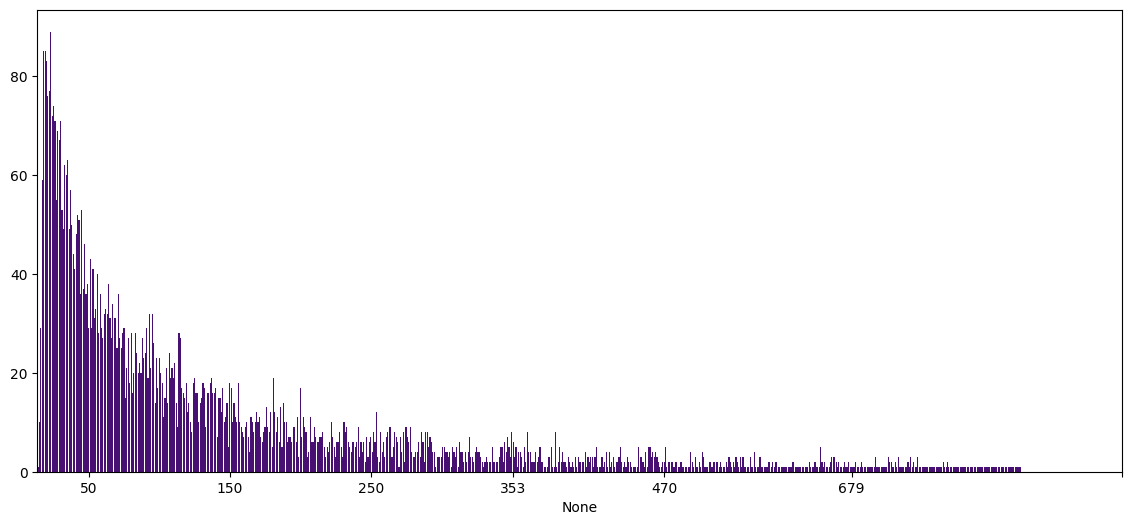

In [ ]:
event_count_per_user = events.groupby('user_id').size().value_counts().sort_index()

plt.figure(figsize=(14, 6))
sns.barplot(x = event_count_per_user.index, y = event_count_per_user.values, color='indigo')

plt.xticks(event_count_per_user.index[22::100])
plt.show()

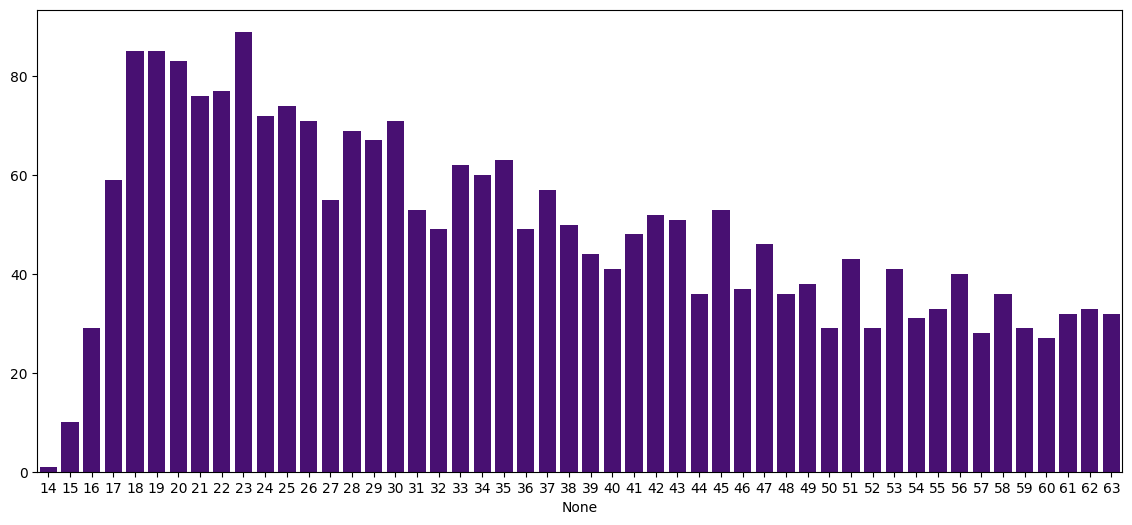

In [ ]:
plt.figure(figsize=(14, 6))
sns.barplot(x = event_count_per_user.index[:50], y = event_count_per_user.values[:50], color='indigo')
plt.show()

Можем заметить, что нам повезло с базой пользователей: минимальное количество айтемов больше 14, то есть у нас нет "холодных" пользователей, по которым мы не можем собрать данные.

**Демография пользователя**

In [ ]:
user_features.gender.value_counts()

,count
gender,
M,4331
F,1709


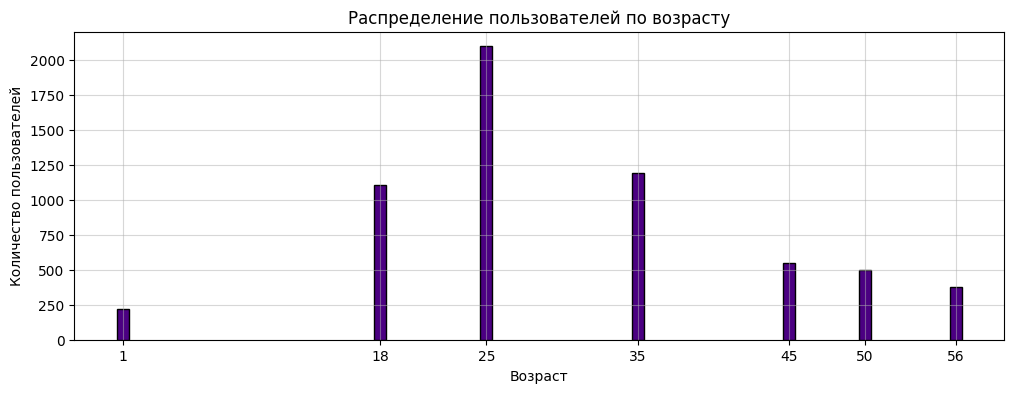

In [ ]:
plt.figure(figsize = (12, 4))
age_pop = user_features.age.value_counts()
x = age_pop.index

plt.bar(age_pop.index, age_pop, edgecolor='black', color = 'indigo')
plt.title('Распределение пользователей по возрасту')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.xticks(x)
plt.grid(alpha = 0.5)
plt.show()

С возрастом что-то интересное, как будто он бьется на какие-то категории. Тем не менее, самая популярная аудитория - пользователи 25 лет, по полу значительно преобладают мужчины.

**Рейтинги фильмов**

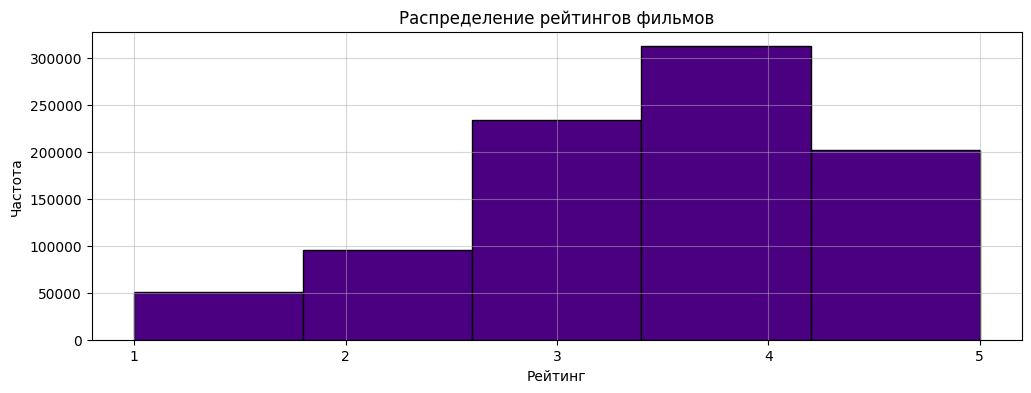

In [ ]:
plt.figure(figsize = (12, 4))

plt.hist(events.rating, bins = 5, edgecolor='black', color = 'indigo')
plt.title('Распределение рейтингов фильмов')
plt.xlabel('Рейтинг')
plt.ylabel('Частота')
plt.xticks([1, 2, 3, 4, 5])
plt.grid(alpha = 0.5)
plt.show()

Видим левостороннюю асимметрию распределения рейтинга, то есть чаще пользователи ставят все же положительные оценки.

**Жанры фильмов**

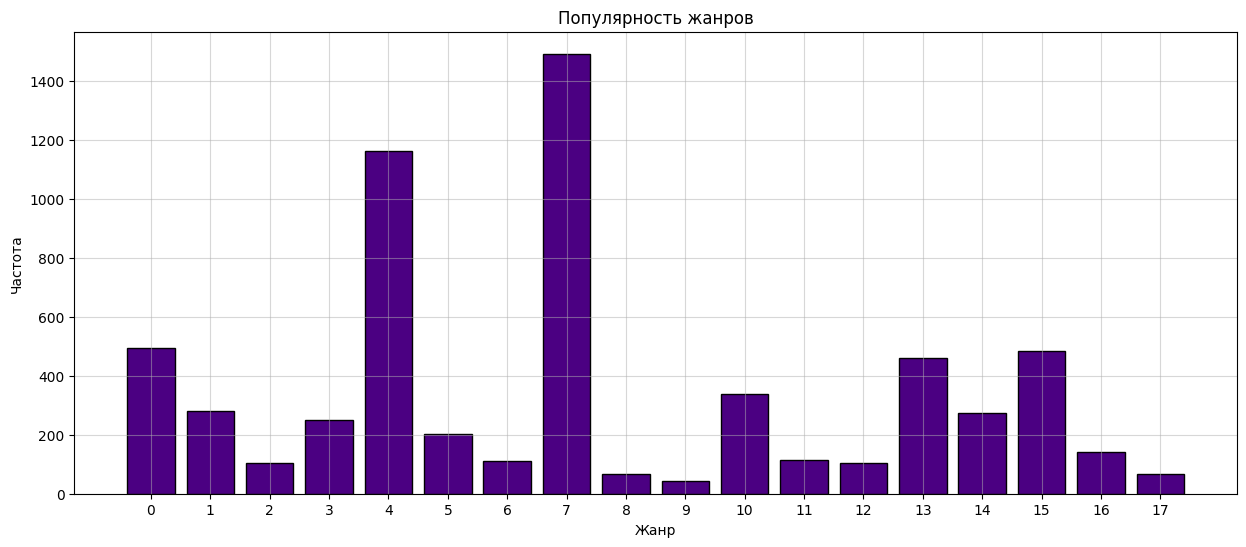

In [ ]:
genre_popularity = item_features.drop(['item_id'], axis = 1).sum(axis = 0)
plt.figure(figsize = (15, 6))
x = np.arange(0, genre_popularity.shape[0])

plt.bar(x, genre_popularity, edgecolor='black', color = 'indigo')
plt.title('Популярность жанров')
plt.xlabel('Жанр')
plt.ylabel('Частота')
plt.xticks(x)
plt.grid(alpha = 0.5)
plt.show()

Фильмы чаще всего относятся к жанрам 7, 4 и 0.

Теперь посмотрим на популярность жанров относительно пользователей:

In [ ]:
# Объединим все датасеты в один
events_with_user_features = events.merge(user_features, on='user_id')
data_merged = events_with_user_features.merge(item_features, on='item_id')

data_merged = data_merged.sort_values(['user_id', 'timestamp']).reset_index(drop=True)

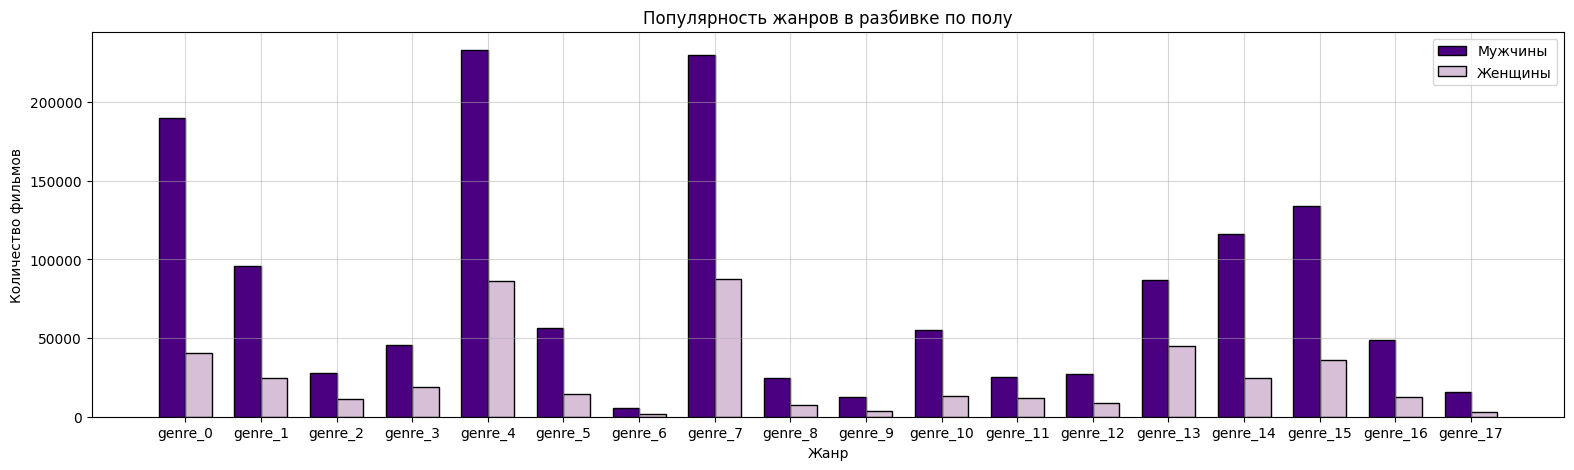

In [ ]:
genre_columns = ['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4','genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10',
       'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17']

popularity_male = data_merged[data_merged['gender'] == 'M'][genre_columns].sum()
popularity_female = data_merged[data_merged['gender'] == 'F'][genre_columns].sum()

x = np.arange(1, len(genre_columns) + 1)
width = 0.35

fig, ax = plt.subplots(figsize=(19, 5))

ax.bar(x - width/2, popularity_male, width, label='Мужчины', color='indigo', edgecolor='black')
ax.bar(x + width/2, popularity_female, width, label='Женщины', color='thistle', edgecolor='black')

ax.set_title('Популярность жанров в разбивке по полу')
ax.set_xlabel('Жанр')
ax.set_ylabel('Количество фильмов')
ax.set_xticks(x)
ax.set_xticklabels(genre_columns)

ax.legend()
ax.grid(alpha=0.5)
plt.show()

Наиболее популярными как у мужчин, так и у женщин являются жанры 7 и 4, при том, что айтемов, относящихся к 4-ому жанру, значительно меньше, чем относящихся к 7-ому. Также среди мужской аудитории популярны жанры 0, 1, 13, 14, 15.

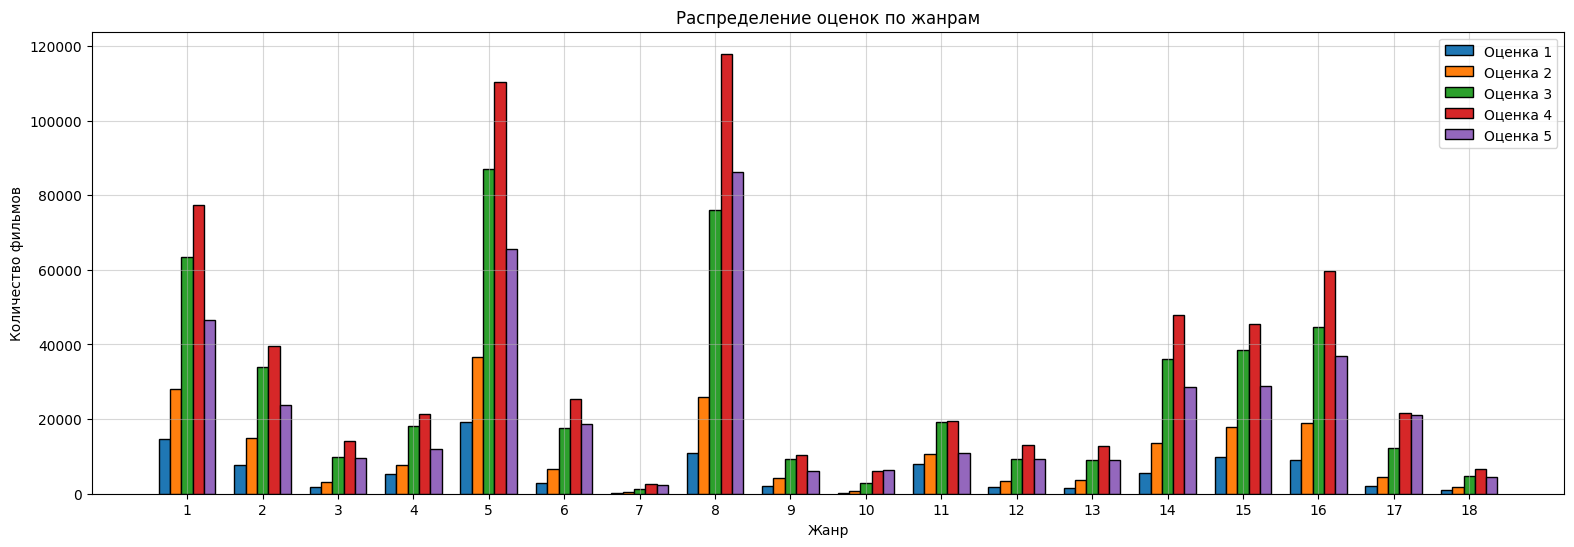

In [ ]:
genre_columns = ['genre_0', 'genre_1', 'genre_2', 'genre_3', 'genre_4','genre_5', 'genre_6', 'genre_7', 'genre_8', 'genre_9', 'genre_10',
       'genre_11', 'genre_12', 'genre_13', 'genre_14', 'genre_15', 'genre_16', 'genre_17']


rating_values = [1, 2, 3, 4, 5]

popularity = pd.DataFrame(0, index = genre_columns, columns = rating_values)

for rating in rating_values:
    popularity[rating] = data_merged[data_merged['rating'] == rating][genre_columns].sum()


x = np.arange(1, len(genre_columns) + 1)
width = 0.15

fig, ax = plt.subplots(figsize=(19, 6))

for i, rating in enumerate(rating_values):
    ax.bar(x + i * width, popularity[rating], width, label = f'Оценка {rating}', edgecolor = 'black')

ax.set_title('Распределение оценок по жанрам')
ax.set_xlabel('Жанр')
ax.set_ylabel('Количество фильмов')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(x)


ax.legend()
ax.grid(alpha = 0.5)
plt.show()

У самых популярных жанров оценка 4 встречается сильно чаще, в остальных распределение более сглаженное.

##Feature Engineering

*Этот блок работы будет использован для модели Catboost*

### Test Data Preparation

Положим последнее событие с каждого пользователя в датасет test: на нём будем отлаживать Recall перед загрузкой посылки в Kaggle.


In [ ]:
test_item = pd.DataFrame(events.groupby('user_id').item_id.last()).reset_index()
test_item.head()

,user_id,item_id
0,0,3360
1,1,584
2,2,2625
3,3,3344
4,4,1868


In [ ]:
test = pd.merge(test_item, data_merged, on=['user_id','item_id'])

In [ ]:
tmp = pd.merge(events, test_item, on=['user_id','item_id'], how='left', indicator='merged_by')
train_items = tmp[tmp.merged_by == 'left_only'][['user_id', 'item_id']]
train = pd.merge(train_items, data_merged, on=['user_id','item_id'])

In [ ]:
train.head()

,user_id,item_id,rating,timestamp,gender,age,genre_0,genre_1,genre_2,genre_3,...,genre_8,genre_9,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17
0,0,1505,4,0,M,35,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,3669,3,1,M,35,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,584,4,2,M,35,1,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,3390,3,3,M,35,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2885,4,4,M,35,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### User-based Features

Сформируем признаки по пользователям.

In [ ]:
# Пол пользователя
user_features['gender'] = np.where(user_features['gender'] == 'M', 1, 0)

In [ ]:
# Количество просмотров фильмов у каждого пользователя
count_interactions = train.groupby('user_id').item_id.count()
count_interactions.name = 'cnt_interact'

In [ ]:
# Средний рейтинг
mean_user_rating = train.groupby('user_id').rating.mean()
mean_user_rating.name = 'avg_user_rat'

In [ ]:
# Суммарные просмотры жанра i
user_most_viewed_genres = train.groupby('user_id')[genre_columns].sum()

In [ ]:
# Ищем 3 самых любимых жанра у пользователя

def get_top_genres(row, n=3):
    return row.nlargest(n).index.tolist()

top_genres = user_most_viewed_genres.apply(get_top_genres, axis=1)

top_genres.name = 'top_genres'
top_genres = top_genres.to_frame()

top_genres = top_genres.assign(
    **{f'top_genre{i+1}': top_genres['top_genres'].apply(lambda x: x[i]) for i in range(3)}
)

top_genres = top_genres.drop('top_genres', axis=1)

In [ ]:
# Корректируем 3 любимых жанра на popularity bias

most_viewed_genres = train[genre_columns].sum()
rel_user_most_viewed_genres = user_most_viewed_genres/most_viewed_genres

rel_top_genres = rel_user_most_viewed_genres.apply(get_top_genres, axis=1)

rel_top_genres.name = 'rel_top_genres'
rel_top_genres = rel_top_genres.to_frame()

rel_top_genres = rel_top_genres.assign(
    **{f'rel_top_genre{i+1}': rel_top_genres['rel_top_genres'].apply(lambda x: x[i]) for i in range(3)}
)

rel_top_genres = rel_top_genres.drop('rel_top_genres', axis=1)

In [ ]:
# Средние значения рейтинга пользователя за последние 5, 10, 50, 100 просмотров

def rolling_mean(df, window_size):
    return df.groupby('user_id')['rating'].apply(
        lambda x: x.rolling(window=window_size, min_periods=0, closed='left').mean()
    )

train['mean_last_5'] = rolling_mean(train, 5).reset_index(level=[0], drop=True).fillna(3.58)
train['mean_last_10'] = rolling_mean(train, 10).reset_index(level=[0], drop=True).fillna(3.58)
train['mean_last_50'] = rolling_mean(train, 50).reset_index(level=[0], drop=True).fillna(3.58)
train['mean_last_100'] = rolling_mean(train, 100).reset_index(level=[0], drop=True).fillna(3.58)

train.head()

,user_id,item_id,rating,timestamp,gender,age,genre_0,genre_1,genre_2,genre_3,...,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,mean_last_5,mean_last_10,mean_last_50,mean_last_100
0,0,1505,4,0,M,35,1,0,0,0,...,0,0,0,0,0,0,3.580000,3.580000,3.580000,3.580000
1,0,3669,3,1,M,35,0,0,0,0,...,0,1,0,0,0,0,4.000000,4.000000,4.000000,4.000000
2,0,584,4,2,M,35,1,1,0,0,...,0,0,1,0,0,0,3.500000,3.500000,3.500000,3.500000
3,0,3390,3,3,M,35,0,0,0,0,...,0,0,0,0,0,0,3.666667,3.666667,3.666667,3.666667
4,0,2885,4,4,M,35,1,0,0,0,...,0,0,0,0,0,0,3.500000,3.500000,3.500000,3.500000


In [ ]:
# Возьмем только последнее значение скользящего окна для пользователя
last_k = pd.DataFrame(train.groupby('user_id').last()).reset_index()
last_k_ratings = last_k[['user_id', 'mean_last_5', 'mean_last_10', 'mean_last_50', 'mean_last_100']]

Сформируем итоговый набор признаков для каждого пользователя:

In [ ]:
user_based_features = user_features.merge(count_interactions.reset_index(), on ='user_id').merge(mean_user_rating.reset_index(), on ='user_id').merge(top_genres.reset_index(), on ='user_id')
user_based_features = user_based_features.merge(rel_top_genres.reset_index(), on ='user_id').merge(last_k_ratings, on ='user_id')
user_based_features.head()

,user_id,gender,age,cnt_interact,avg_user_rat,top_genre1,top_genre2,top_genre3,rel_top_genre1,rel_top_genre2,rel_top_genre3,mean_last_5,mean_last_10,mean_last_50,mean_last_100
0,4855,0,1,42,4.166667,genre_7,genre_3,genre_2,genre_2,genre_11,genre_3,4.4,4.2,4.170732,4.170732
1,4065,1,56,117,3.692308,genre_7,genre_0,genre_15,genre_7,genre_16,genre_0,3.0,3.2,3.360000,3.620000
2,3331,1,25,44,3.954545,genre_4,genre_1,genre_0,genre_17,genre_1,genre_0,3.4,3.5,3.953488,3.953488
3,5373,1,45,16,4.187500,genre_0,genre_14,genre_1,genre_0,genre_17,genre_14,4.4,4.7,4.133333,4.133333
4,2032,1,25,170,3.170588,genre_7,genre_4,genre_15,genre_6,genre_5,genre_7,3.2,3.2,2.800000,3.140000


### Item-Based Features

Теперь соберем признаки по каждому айтему.

In [ ]:
# Средний рейтинг фильма
item_mean_rating = train.groupby('item_id').rating.mean()
item_mean_rating.name = 'avg_item_rat'

In [ ]:
# Количество пользователей, посмотревших каждый фильм
count_interactions_movie = train.groupby('item_id').user_id.count()
count_interactions_movie.name = 'cnt_interact_movie'

In [ ]:
# Средний рейтинг жанра
mean_ratings_by_genre = [train[train[f'genre_{i}'] == 1].rating.mean() for i in range(18)]
mean_ratings_by_genre = pd.Series(mean_ratings_by_genre, index=genre_columns)

Сформируем итоговый набор признаков для каждого фильма:

In [ ]:
item_based_features = item_features.merge(item_mean_rating.reset_index(), on = 'item_id').merge(count_interactions_movie.reset_index(), on = 'item_id')
item_based_features.head()

,item_id,genre_0,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,...,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,avg_item_rat,cnt_interact_movie
0,0,0,1,0,1,1,0,0,0,1,...,0,0,0,1,0,0,0,0,2.398496,133
1,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.307692,13
2,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.649770,217
3,3,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,3.959459,148
4,4,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,3.590909,44


##Bert4Rec (Recall@10 = 0.1703)

Реализация модели взята [здесь](https://github.com/sb-ai-lab/RePlay/blob/main/examples/10_bert4rec_example.ipynb).

### Подготовка данных для Bert4Rec модели

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
spark_session = get_spark_session()

In [ ]:
interactions = pd.read_csv('/content/drive/MyDrive/bmmo/events.csv')
user_features = pd.read_csv('/content/drive/MyDrive/bmmo/user_features.csv')
item_features = pd.read_csv('/content/drive/MyDrive/bmmo/item_features.csv')

In [ ]:
interactions["timestamp"] = interactions["timestamp"].astype("int64")
interactions = interactions.sort_values(by="timestamp")
interactions["timestamp"] = interactions.groupby("user_id").cumcount()
interactions

,user_id,item_id,rating,timestamp
1000138,6040,858,4,0
1000153,6040,2384,4,1
999873,6040,593,5,2
1000007,6040,1961,4,3
1000192,6040,2019,5,4
...,...,...,...,...
825793,4958,2399,1,446
825438,4958,1407,5,447
825724,4958,3264,4,448
825731,4958,2634,3,449


Делим выборку на тренировочную, тестовую, валидационную

In [ ]:
splitter = LastNSplitter(
    N=1,
    divide_column="user_id",
    query_column="user_id",
    strategy="interactions",
)

raw_test_events, raw_test_gt = splitter.split(interactions)
raw_validation_events, raw_validation_gt = splitter.split(raw_test_events)
raw_train_events = raw_validation_events

In [ ]:
def prepare_feature_schema(is_ground_truth: bool) -> FeatureSchema:
    base_features = FeatureSchema(
        [
            FeatureInfo(
                column="user_id",
                feature_hint=FeatureHint.QUERY_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
            FeatureInfo(
                column="item_id",
                feature_hint=FeatureHint.ITEM_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
        ]
    )
    if is_ground_truth:
        return base_features

    all_features = base_features + FeatureSchema(
        [
            FeatureInfo(
                column="timestamp",
                feature_type=FeatureType.NUMERICAL,
                feature_hint=FeatureHint.TIMESTAMP,
            ),
        ]
    )
    return all_features

Датасет для обучения:

In [ ]:
train_dataset = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=False),
    interactions=raw_train_events,
    query_features=user_features,
    item_features=item_features,
    check_consistency=True,
    categorical_encoded=False,
)

Датасет для валидации:

In [ ]:
validation_dataset = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=False),
    interactions=raw_validation_events,
    query_features=user_features,
    item_features=item_features,
    check_consistency=True,
    categorical_encoded=False,
)
validation_gt = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=True),
    interactions=raw_validation_gt,
    check_consistency=True,
    categorical_encoded=False,
)

Датасет для теста:

In [ ]:
test_dataset = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=False),
    interactions=raw_test_events,
    query_features=user_features,
    item_features=item_features,
    check_consistency=True,
    categorical_encoded=False,
)
test_gt = Dataset(
    feature_schema=prepare_feature_schema(is_ground_truth=True),
    interactions=raw_test_gt,
    check_consistency=True,
    categorical_encoded=False,
)

Tensor schema:

In [ ]:
ITEM_FEATURE_NAME = "item_id_seq"

tensor_schema = TensorSchema(
    TensorFeatureInfo(
        name=ITEM_FEATURE_NAME,
        is_seq=True,
        feature_type=FeatureType.CATEGORICAL,
        feature_sources=[TensorFeatureSource(FeatureSource.INTERACTIONS, train_dataset.feature_schema.item_id_column)],
        feature_hint=FeatureHint.ITEM_ID,
        embedding_dim=300,
    )
)

In [ ]:
tokenizer = SequenceTokenizer(tensor_schema, allow_collect_to_master=True)
tokenizer.fit(train_dataset)

sequential_train_dataset = tokenizer.transform(train_dataset)

sequential_validation_dataset = tokenizer.transform(validation_dataset)
sequential_validation_gt = tokenizer.transform(validation_gt, [tensor_schema.item_id_feature_name])

sequential_validation_dataset, sequential_validation_gt = SequentialDataset.keep_common_query_ids(
    sequential_validation_dataset, sequential_validation_gt
)

In [ ]:
test_query_ids = test_gt.query_ids
test_query_ids_np = tokenizer.query_id_encoder.transform(test_query_ids)["user_id"].values
sequential_test_dataset = tokenizer.transform(test_dataset).filter_by_query_id(test_query_ids_np)

In [ ]:
print(tokenizer.query_id_encoder.mapping, tokenizer.query_id_encoder.inverse_mapping)
print(tokenizer.item_id_encoder.mapping, tokenizer.item_id_encoder.inverse_mapping)

{'user_id': {4855: 0, 4065: 1, 3331: 2, 5373: 3, 2032: 4, 5875: 5, 3984: 6, 4062: 7, 5117: 8, 5822: 9, 174: 10, 5188: 11, 595: 12, 2538: 13, 5031: 14, 4765: 15, 1819: 16, 3970: 17, 568: 18, 4007: 19, 2641: 20, 2646: 21, 3839: 22, 3263: 23, 281: 24, 2009: 25, 5836: 26, 1581: 27, 679: 28, 3634: 29, 2401: 30, 2184: 31, 5532: 32, 3638: 33, 4159: 34, 1770: 35, 3754: 36, 637: 37, 1452: 38, 5412: 39, 5345: 40, 3078: 41, 4772: 42, 3484: 43, 1064: 44, 2812: 45, 3120: 46, 4295: 47, 491: 48, 3283: 49, 5595: 50, 622: 51, 4428: 52, 1570: 53, 4561: 54, 3927: 55, 127: 56, 1950: 57, 1877: 58, 2285: 59, 656: 60, 462: 61, 4055: 62, 4477: 63, 2148: 64, 1582: 65, 272: 66, 3556: 67, 883: 68, 5295: 69, 3223: 70, 4070: 71, 3: 72, 5314: 73, 4225: 74, 1341: 75, 5909: 76, 1413: 77, 4463: 78, 3900: 79, 4426: 80, 811: 81, 3491: 82, 5118: 83, 2018: 84, 1308: 85, 4379: 86, 4351: 87, 2995: 88, 3680: 89, 1336: 90, 3758: 91, 1286: 92, 5003: 93, 3574: 94, 1703: 95, 1855: 96, 32: 97, 5901: 98, 5207: 99, 1516: 100, 5457:

### Обучение модели

In [ ]:
MAX_SEQ_LEN = 100
BATCH_SIZE = 512
NUM_WORKERS = 4

model = Bert4Rec(
    tensor_schema,
    block_count=2,
    head_count=4,
    max_seq_len=MAX_SEQ_LEN,
    hidden_size=300,
    dropout_rate=0.5,
    optimizer_factory=FatOptimizerFactory(learning_rate=0.001),
)
checkpoint_callback = ModelCheckpoint(
    dirpath=".checkpoints",
    save_top_k=1,
    verbose=True,
    monitor="recall@10",
    mode="max",
)

validation_metrics_callback = ValidationMetricsCallback(
    metrics=["map", "ndcg", "recall"],
    ks=[1, 5, 10, 20],
    item_count=train_dataset.item_count,
    postprocessors=[RemoveSeenItems(sequential_validation_dataset)]
)

csv_logger = CSVLogger(save_dir=".logs/train", name="Bert4Rec_example")

trainer = L.Trainer(
    max_epochs=200,
    callbacks=[checkpoint_callback, validation_metrics_callback],
    logger=csv_logger,
)

train_dataloader = DataLoader(
    dataset=Bert4RecTrainingDataset(
        sequential_train_dataset,
        max_sequence_length=MAX_SEQ_LEN,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

validation_dataloader = DataLoader(
    dataset=Bert4RecValidationDataset(
        sequential_validation_dataset,
        sequential_validation_gt,
        sequential_train_dataset,
        max_sequence_length=MAX_SEQ_LEN,
    ),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

trainer.fit(
    model,
    train_dataloaders=train_dataloader,
    val_dataloaders=validation_dataloader,
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type           

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 12: 'recall@10' reached 0.03576 (best 0.03576), saving model to '/content/.checkpoints/epoch=0-step=12.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 12: 'recall@10' reached 0.03576 (best 0.03576), saving model to '/content/.checkpoints/epoch=0-step=12.ckpt' as top 1


k              1        10        20         5
map     0.003642  0.010572  0.012509  0.008297
ndcg    0.003642  0.016342  0.023493  0.010766
recall  0.003642  0.035762  0.064238  0.018377



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 24: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 24: 'recall@10' was not in top 1


k              1        10        20         5
map     0.004305  0.011176  0.013119  0.009280
ndcg    0.004305  0.016450  0.023580  0.011755
recall  0.004305  0.034106  0.062417  0.019371



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 36: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 36: 'recall@10' was not in top 1


k              1        10        20         5
map     0.003974  0.010555  0.012558  0.008584
ndcg    0.003974  0.015770  0.023224  0.010907
recall  0.003974  0.033278  0.063079  0.018046



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 48: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 3, global step 48: 'recall@10' was not in top 1


k              1        10        20         5
map     0.003974  0.010672  0.012410  0.008231
ndcg    0.003974  0.016399  0.022917  0.010469
recall  0.003974  0.035762  0.061921  0.017384



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 60: 'recall@10' reached 0.03858 (best 0.03858), saving model to '/content/.checkpoints/epoch=4-step=60.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 4, global step 60: 'recall@10' reached 0.03858 (best 0.03858), saving model to '/content/.checkpoints/epoch=4-step=60.ckpt' as top 1


k              1        10        20         5
map     0.003642  0.010977  0.012812  0.008601
ndcg    0.003642  0.017261  0.024066  0.011272
recall  0.003642  0.038576  0.065728  0.019536



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 72: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 5, global step 72: 'recall@10' was not in top 1


k              1        10        20         5
map     0.003974  0.010792  0.012815  0.008940
ndcg    0.003974  0.016004  0.023455  0.011417
recall  0.003974  0.033444  0.063079  0.019040



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 84: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 6, global step 84: 'recall@10' was not in top 1


k              1        10        20         5
map     0.003642  0.009910  0.011840  0.007632
ndcg    0.003642  0.015368  0.022617  0.009694
recall  0.003642  0.033940  0.063079  0.016060



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 96: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 7, global step 96: 'recall@10' was not in top 1


k             1        10        20         5
map     0.00298  0.009068  0.011149  0.006818
ndcg    0.00298  0.014445  0.022052  0.008800
recall  0.00298  0.032781  0.062914  0.014901



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 108: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 8, global step 108: 'recall@10' was not in top 1


k              1        10        20         5
map     0.003311  0.009385  0.011686  0.007434
ndcg    0.003311  0.014348  0.023052  0.009661
recall  0.003311  0.030960  0.066060  0.016556



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 120: 'recall@10' reached 0.04123 (best 0.04123), saving model to '/content/.checkpoints/epoch=9-step=120.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 9, global step 120: 'recall@10' reached 0.04123 (best 0.04123), saving model to '/content/.checkpoints/epoch=9-step=120.ckpt' as top 1


k              1        10        20         5
map     0.004636  0.012505  0.014698  0.009785
ndcg    0.004636  0.019063  0.027273  0.012382
recall  0.004636  0.041225  0.074172  0.020364



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 10, global step 132: 'recall@10' reached 0.04371 (best 0.04371), saving model to '/content/.checkpoints/epoch=10-step=132.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 10, global step 132: 'recall@10' reached 0.04371 (best 0.04371), saving model to '/content/.checkpoints/epoch=10-step=132.ckpt' as top 1


k              1        10        20         5
map     0.003311  0.012245  0.014279  0.009467
ndcg    0.003311  0.019465  0.027067  0.012662
recall  0.003311  0.043709  0.074172  0.022517



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 11, global step 144: 'recall@10' reached 0.04487 (best 0.04487), saving model to '/content/.checkpoints/epoch=11-step=144.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 11, global step 144: 'recall@10' reached 0.04487 (best 0.04487), saving model to '/content/.checkpoints/epoch=11-step=144.ckpt' as top 1


k              1        10        20         5
map     0.005132  0.013672  0.015979  0.011065
ndcg    0.005132  0.020826  0.029374  0.014383
recall  0.005132  0.044868  0.078974  0.024669



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 12, global step 156: 'recall@10' reached 0.04884 (best 0.04884), saving model to '/content/.checkpoints/epoch=12-step=156.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 12, global step 156: 'recall@10' reached 0.04884 (best 0.04884), saving model to '/content/.checkpoints/epoch=12-step=156.ckpt' as top 1


k              1        10        20         5
map     0.005795  0.014884  0.017313  0.011995
ndcg    0.005795  0.022650  0.031598  0.015517
recall  0.005795  0.048841  0.084437  0.026490



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 13, global step 168: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 13, global step 168: 'recall@10' was not in top 1


k              1        10        20         5
map     0.005298  0.014339  0.016910  0.011440
ndcg    0.005298  0.021747  0.031258  0.014603
recall  0.005298  0.046689  0.084603  0.024338



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 14, global step 180: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 14, global step 180: 'recall@10' was not in top 1


k              1        10        20         5
map     0.005298  0.014520  0.016999  0.011912
ndcg    0.005298  0.021801  0.031086  0.015357
recall  0.005298  0.046192  0.083444  0.025993



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 15, global step 192: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 15, global step 192: 'recall@10' was not in top 1


k              1        10        20         5
map     0.006788  0.016297  0.018895  0.013604
ndcg    0.006788  0.023563  0.033438  0.016940
recall  0.006788  0.047848  0.087748  0.027152



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 16, global step 204: 'recall@10' reached 0.05050 (best 0.05050), saving model to '/content/.checkpoints/epoch=16-step=204.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 16, global step 204: 'recall@10' reached 0.05050 (best 0.05050), saving model to '/content/.checkpoints/epoch=16-step=204.ckpt' as top 1


k              1        10        20         5
map     0.006623  0.016817  0.019718  0.013836
ndcg    0.006623  0.024558  0.035359  0.017238
recall  0.006623  0.050497  0.093709  0.027649



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 17, global step 216: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 17, global step 216: 'recall@10' was not in top 1


k              1        10        20         5
map     0.006126  0.016038  0.019033  0.013024
ndcg    0.006126  0.023915  0.035028  0.016531
recall  0.006126  0.050331  0.094702  0.027318



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 18, global step 228: 'recall@10' reached 0.05149 (best 0.05149), saving model to '/content/.checkpoints/epoch=18-step=228.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 18, global step 228: 'recall@10' reached 0.05149 (best 0.05149), saving model to '/content/.checkpoints/epoch=18-step=228.ckpt' as top 1


k              1        10        20         5
map     0.006291  0.016194  0.019060  0.013195
ndcg    0.006291  0.024282  0.035018  0.016818
recall  0.006291  0.051490  0.094536  0.027980



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 19, global step 240: 'recall@10' reached 0.05530 (best 0.05530), saving model to '/content/.checkpoints/epoch=19-step=240.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 19, global step 240: 'recall@10' reached 0.05530 (best 0.05530), saving model to '/content/.checkpoints/epoch=19-step=240.ckpt' as top 1


k              1        10        20         5
map     0.006954  0.017794  0.020669  0.014498
ndcg    0.006954  0.026400  0.037146  0.018292
recall  0.006954  0.055298  0.098344  0.029967



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 20, global step 252: 'recall@10' reached 0.05894 (best 0.05894), saving model to '/content/.checkpoints/epoch=20-step=252.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 20, global step 252: 'recall@10' reached 0.05894 (best 0.05894), saving model to '/content/.checkpoints/epoch=20-step=252.ckpt' as top 1


k              1        10        20         5
map     0.007781  0.018742  0.021691  0.015262
ndcg    0.007781  0.027931  0.038874  0.019296
recall  0.007781  0.058940  0.102649  0.031788



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 21, global step 264: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 21, global step 264: 'recall@10' was not in top 1


k             1        10        20         5
map     0.00745  0.018368  0.021651  0.015259
ndcg    0.00745  0.027012  0.039225  0.019345
recall  0.00745  0.055960  0.104801  0.031954



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 22, global step 276: 'recall@10' reached 0.05960 (best 0.05960), saving model to '/content/.checkpoints/epoch=22-step=276.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 22, global step 276: 'recall@10' reached 0.05960 (best 0.05960), saving model to '/content/.checkpoints/epoch=22-step=276.ckpt' as top 1


k              1        10        20         5
map     0.007947  0.019720  0.022969  0.016482
ndcg    0.007947  0.028899  0.041018  0.020881
recall  0.007947  0.059603  0.108113  0.034437



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 23, global step 288: 'recall@10' reached 0.06639 (best 0.06639), saving model to '/content/.checkpoints/epoch=23-step=288.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 23, global step 288: 'recall@10' reached 0.06639 (best 0.06639), saving model to '/content/.checkpoints/epoch=23-step=288.ckpt' as top 1


k              1        10        20         5
map     0.008113  0.021038  0.024620  0.017001
ndcg    0.008113  0.031428  0.044784  0.021448
recall  0.008113  0.066391  0.119868  0.035099



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 24, global step 300: 'recall@10' reached 0.07020 (best 0.07020), saving model to '/content/.checkpoints/epoch=24-step=300.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 24, global step 300: 'recall@10' reached 0.07020 (best 0.07020), saving model to '/content/.checkpoints/epoch=24-step=300.ckpt' as top 1


k              1        10        20         5
map     0.008113  0.022035  0.026048  0.017884
ndcg    0.008113  0.033090  0.047837  0.022808
recall  0.008113  0.070199  0.128808  0.037914



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 25, global step 312: 'recall@10' reached 0.08079 (best 0.08079), saving model to '/content/.checkpoints/epoch=25-step=312.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 25, global step 312: 'recall@10' reached 0.08079 (best 0.08079), saving model to '/content/.checkpoints/epoch=25-step=312.ckpt' as top 1


k              1        10        20         5
map     0.009768  0.025981  0.029944  0.021374
ndcg    0.009768  0.038583  0.053489  0.027185
recall  0.009768  0.080795  0.140728  0.045033



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 26, global step 324: 'recall@10' reached 0.09702 (best 0.09702), saving model to '/content/.checkpoints/epoch=26-step=324.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 26, global step 324: 'recall@10' reached 0.09702 (best 0.09702), saving model to '/content/.checkpoints/epoch=26-step=324.ckpt' as top 1


k             1        10        20         5
map     0.01043  0.030337  0.035269  0.024666
ndcg    0.01043  0.045697  0.064018  0.031789
recall  0.01043  0.097020  0.170199  0.053642



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 27, global step 336: 'recall@10' reached 0.10911 (best 0.10911), saving model to '/content/.checkpoints/epoch=27-step=336.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 27, global step 336: 'recall@10' reached 0.10911 (best 0.10911), saving model to '/content/.checkpoints/epoch=27-step=336.ckpt' as top 1


k              1        10        20         5
map     0.015397  0.036470  0.042022  0.030088
ndcg    0.015397  0.053161  0.073688  0.037567
recall  0.015397  0.109106  0.190894  0.060596



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 28, global step 348: 'recall@10' reached 0.11606 (best 0.11606), saving model to '/content/.checkpoints/epoch=28-step=348.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 28, global step 348: 'recall@10' reached 0.11606 (best 0.11606), saving model to '/content/.checkpoints/epoch=28-step=348.ckpt' as top 1


k              1        10        20         5
map     0.016391  0.039230  0.044615  0.032715
ndcg    0.016391  0.056917  0.077007  0.040939
recall  0.016391  0.116060  0.196523  0.066225



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 29, global step 360: 'recall@10' reached 0.12334 (best 0.12334), saving model to '/content/.checkpoints/epoch=29-step=360.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 29, global step 360: 'recall@10' reached 0.12334 (best 0.12334), saving model to '/content/.checkpoints/epoch=29-step=360.ckpt' as top 1


k              1        10        20         5
map     0.018046  0.042133  0.048252  0.034945
ndcg    0.018046  0.060757  0.083444  0.042909
recall  0.018046  0.123344  0.213907  0.067219



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 30, global step 372: 'recall@10' reached 0.13311 (best 0.13311), saving model to '/content/.checkpoints/epoch=30-step=372.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 30, global step 372: 'recall@10' reached 0.13311 (best 0.13311), saving model to '/content/.checkpoints/epoch=30-step=372.ckpt' as top 1


k              1        10        20         5
map     0.019702  0.045917  0.052343  0.038435
ndcg    0.019702  0.065998  0.089454  0.047669
recall  0.019702  0.133113  0.225993  0.075993



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 31, global step 384: 'recall@10' reached 0.14387 (best 0.14387), saving model to '/content/.checkpoints/epoch=31-step=384.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 31, global step 384: 'recall@10' reached 0.14387 (best 0.14387), saving model to '/content/.checkpoints/epoch=31-step=384.ckpt' as top 1


k              1        10        20         5
map     0.021854  0.050610  0.057040  0.043038
ndcg    0.021854  0.072160  0.096010  0.053551
recall  0.021854  0.143874  0.239073  0.085762



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 32, global step 396: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 32, global step 396: 'recall@10' was not in top 1


k              1        10        20         5
map     0.020695  0.048902  0.054879  0.041214
ndcg    0.020695  0.070070  0.091979  0.051125
recall  0.020695  0.140728  0.227649  0.081457



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 33, global step 408: 'recall@10' reached 0.14752 (best 0.14752), saving model to '/content/.checkpoints/epoch=33-step=408.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 33, global step 408: 'recall@10' reached 0.14752 (best 0.14752), saving model to '/content/.checkpoints/epoch=33-step=408.ckpt' as top 1


k              1        10        20         5
map     0.022517  0.052658  0.058880  0.045293
ndcg    0.022517  0.074604  0.097529  0.056427
recall  0.022517  0.147517  0.238742  0.090563



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 34, global step 420: 'recall@10' reached 0.14851 (best 0.14851), saving model to '/content/.checkpoints/epoch=34-step=420.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 34, global step 420: 'recall@10' reached 0.14851 (best 0.14851), saving model to '/content/.checkpoints/epoch=34-step=420.ckpt' as top 1


k              1        10        20         5
map     0.023841  0.053677  0.059958  0.045527
ndcg    0.023841  0.075602  0.098685  0.055818
recall  0.023841  0.148510  0.240232  0.087252



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 35, global step 432: 'recall@10' reached 0.15795 (best 0.15795), saving model to '/content/.checkpoints/epoch=35-step=432.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 35, global step 432: 'recall@10' reached 0.15795 (best 0.15795), saving model to '/content/.checkpoints/epoch=35-step=432.ckpt' as top 1


k              1        10        20         5
map     0.020695  0.052767  0.059260  0.043866
ndcg    0.020695  0.077044  0.100800  0.055344
recall  0.020695  0.157947  0.252152  0.090563



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 36, global step 444: 'recall@10' reached 0.16010 (best 0.16010), saving model to '/content/.checkpoints/epoch=36-step=444.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 36, global step 444: 'recall@10' reached 0.16010 (best 0.16010), saving model to '/content/.checkpoints/epoch=36-step=444.ckpt' as top 1


k              1        10        20         5
map     0.022848  0.055329  0.061991  0.046675
ndcg    0.022848  0.079516  0.104015  0.058222
recall  0.022848  0.160099  0.257450  0.093543



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 37, global step 456: 'recall@10' reached 0.16308 (best 0.16308), saving model to '/content/.checkpoints/epoch=37-step=456.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 37, global step 456: 'recall@10' reached 0.16308 (best 0.16308), saving model to '/content/.checkpoints/epoch=37-step=456.ckpt' as top 1


k              1        10        20         5
map     0.026325  0.058620  0.065216  0.049752
ndcg    0.026325  0.082708  0.107039  0.060950
recall  0.026325  0.163079  0.259934  0.095199



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 38, global step 468: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 38, global step 468: 'recall@10' was not in top 1


k              1        10        20         5
map     0.024503  0.057450  0.063996  0.049412
ndcg    0.024503  0.081422  0.105743  0.061659
recall  0.024503  0.160927  0.258113  0.099172



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 39, global step 480: 'recall@10' reached 0.16391 (best 0.16391), saving model to '/content/.checkpoints/epoch=39-step=480.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 39, global step 480: 'recall@10' reached 0.16391 (best 0.16391), saving model to '/content/.checkpoints/epoch=39-step=480.ckpt' as top 1


k              1        10        20         5
map     0.025331  0.058168  0.064468  0.049396
ndcg    0.025331  0.082655  0.106066  0.061463
recall  0.025331  0.163907  0.257450  0.098510



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 40, global step 492: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 40, global step 492: 'recall@10' was not in top 1


k              1        10        20         5
map     0.027483  0.059127  0.065700  0.050778
ndcg    0.027483  0.082905  0.106906  0.062423
recall  0.027483  0.162086  0.257119  0.098179



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 41, global step 504: 'recall@10' reached 0.16904 (best 0.16904), saving model to '/content/.checkpoints/epoch=41-step=504.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 41, global step 504: 'recall@10' reached 0.16904 (best 0.16904), saving model to '/content/.checkpoints/epoch=41-step=504.ckpt' as top 1


k              1        10        20         5
map     0.026821  0.060382  0.066977  0.050866
ndcg    0.026821  0.085442  0.109632  0.062248
recall  0.026821  0.169040  0.265066  0.097020



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 42, global step 516: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 42, global step 516: 'recall@10' was not in top 1


k              1        10        20         5
map     0.026656  0.060661  0.067476  0.051868
ndcg    0.026656  0.085425  0.110443  0.063867
recall  0.026656  0.167715  0.267053  0.100497



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 43, global step 528: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 43, global step 528: 'recall@10' was not in top 1


k           1        10        20         5
map     0.025  0.058441  0.064839  0.049211
ndcg    0.025  0.083460  0.107103  0.060898
recall  0.025  0.166887  0.261093  0.096689



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 44, global step 540: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 44, global step 540: 'recall@10' was not in top 1


k              1        10        20         5
map     0.027483  0.062112  0.068590  0.053775
ndcg    0.027483  0.086858  0.110659  0.066539
recall  0.027483  0.168709  0.263245  0.105629



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 45, global step 552: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 45, global step 552: 'recall@10' was not in top 1


k             1        10        20         5
map     0.02649  0.060139  0.066823  0.051749
ndcg    0.02649  0.084677  0.109280  0.064182
recall  0.02649  0.166060  0.263907  0.102318



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 46, global step 564: 'recall@10' reached 0.17450 (best 0.17450), saving model to '/content/.checkpoints/epoch=46-step=564.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 46, global step 564: 'recall@10' reached 0.17450 (best 0.17450), saving model to '/content/.checkpoints/epoch=46-step=564.ckpt' as top 1


k              1        10        20         5
map     0.026325  0.061620  0.067951  0.052655
ndcg    0.026325  0.087718  0.111082  0.065644
recall  0.026325  0.174503  0.267550  0.105464



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 47, global step 576: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 47, global step 576: 'recall@10' was not in top 1


k              1        10        20         5
map     0.027318  0.062757  0.069768  0.053929
ndcg    0.027318  0.088167  0.113897  0.066667
recall  0.027318  0.172351  0.274503  0.105629



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 48, global step 588: 'recall@10' reached 0.17897 (best 0.17897), saving model to '/content/.checkpoints/epoch=48-step=588.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 48, global step 588: 'recall@10' reached 0.17897 (best 0.17897), saving model to '/content/.checkpoints/epoch=48-step=588.ckpt' as top 1


k              1        10        20         5
map     0.028146  0.064176  0.070967  0.054972
ndcg    0.028146  0.090715  0.115731  0.068086
recall  0.028146  0.178974  0.278477  0.108278



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 49, global step 600: 'recall@10' reached 0.18361 (best 0.18361), saving model to '/content/.checkpoints/epoch=49-step=600.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 49, global step 600: 'recall@10' reached 0.18361 (best 0.18361), saving model to '/content/.checkpoints/epoch=49-step=600.ckpt' as top 1


k              1        10        20         5
map     0.028146  0.065077  0.071943  0.055737
ndcg    0.028146  0.092496  0.117822  0.069639
recall  0.028146  0.183609  0.284437  0.112417



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 50, global step 612: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 50, global step 612: 'recall@10' was not in top 1


k              1        10        20         5
map     0.030629  0.064180  0.071380  0.054992
ndcg    0.030629  0.089858  0.116154  0.067341
recall  0.030629  0.175497  0.279636  0.105298



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 51, global step 624: 'recall@10' reached 0.18593 (best 0.18593), saving model to '/content/.checkpoints/epoch=51-step=624.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 51, global step 624: 'recall@10' reached 0.18593 (best 0.18593), saving model to '/content/.checkpoints/epoch=51-step=624.ckpt' as top 1


k              1        10        20         5
map     0.028477  0.065431  0.072230  0.055290
ndcg    0.028477  0.093236  0.118177  0.068409
recall  0.028477  0.185927  0.284934  0.108609



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 52, global step 636: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 52, global step 636: 'recall@10' was not in top 1


k              1        10        20         5
map     0.029636  0.066913  0.073821  0.057715
ndcg    0.029636  0.093691  0.119183  0.071386
recall  0.029636  0.182285  0.283775  0.113245



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 53, global step 648: 'recall@10' reached 0.18758 (best 0.18758), saving model to '/content/.checkpoints/epoch=53-step=648.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 53, global step 648: 'recall@10' reached 0.18758 (best 0.18758), saving model to '/content/.checkpoints/epoch=53-step=648.ckpt' as top 1


k              1        10        20         5
map     0.027815  0.067287  0.074383  0.057621
ndcg    0.027815  0.095211  0.121488  0.071679
recall  0.027815  0.187583  0.292384  0.114570



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 54, global step 660: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 54, global step 660: 'recall@10' was not in top 1


k              1        10        20         5
map     0.026987  0.064668  0.071983  0.055905
ndcg    0.026987  0.091542  0.118555  0.070106
recall  0.026987  0.180298  0.287914  0.113576



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 55, global step 672: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 55, global step 672: 'recall@10' was not in top 1


k              1        10        20         5
map     0.028642  0.065395  0.072414  0.056534
ndcg    0.028642  0.091967  0.117676  0.070309
recall  0.028642  0.179967  0.281954  0.112583



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 56, global step 684: 'recall@10' reached 0.19139 (best 0.19139), saving model to '/content/.checkpoints/epoch=56-step=684.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 56, global step 684: 'recall@10' reached 0.19139 (best 0.19139), saving model to '/content/.checkpoints/epoch=56-step=684.ckpt' as top 1


k              1        10        20         5
map     0.028642  0.067923  0.075008  0.058107
ndcg    0.028642  0.096581  0.122624  0.072933
recall  0.028642  0.191391  0.294868  0.118543



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 57, global step 696: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 57, global step 696: 'recall@10' was not in top 1


k              1        10        20         5
map     0.027483  0.066455  0.074138  0.056863
ndcg    0.027483  0.094964  0.123266  0.071319
recall  0.027483  0.189570  0.302152  0.115563



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 58, global step 708: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 58, global step 708: 'recall@10' was not in top 1


k              1        10        20         5
map     0.026656  0.065924  0.072494  0.055800
ndcg    0.026656  0.094170  0.118358  0.069486
recall  0.026656  0.187914  0.284106  0.111258



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 59, global step 720: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 59, global step 720: 'recall@10' was not in top 1


k              1        10        20         5
map     0.028477  0.067670  0.074918  0.057975
ndcg    0.028477  0.096095  0.123026  0.072315
recall  0.028477  0.190397  0.298013  0.116225



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 60, global step 732: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 60, global step 732: 'recall@10' was not in top 1


k              1        10        20         5
map     0.029801  0.069063  0.076311  0.059335
ndcg    0.029801  0.097400  0.124138  0.073551
recall  0.029801  0.191391  0.297848  0.117053



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 61, global step 744: 'recall@10' reached 0.19156 (best 0.19156), saving model to '/content/.checkpoints/epoch=61-step=744.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 61, global step 744: 'recall@10' reached 0.19156 (best 0.19156), saving model to '/content/.checkpoints/epoch=61-step=744.ckpt' as top 1


k              1        10        20         5
map     0.034603  0.072983  0.080481  0.063306
ndcg    0.034603  0.100498  0.127910  0.077081
recall  0.034603  0.191556  0.300166  0.119205



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 62, global step 756: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 62, global step 756: 'recall@10' was not in top 1


k              1        10        20         5
map     0.029967  0.067198  0.074856  0.057652
ndcg    0.029967  0.094201  0.122418  0.070850
recall  0.029967  0.183775  0.296026  0.111093



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 63, global step 768: 'recall@10' reached 0.19172 (best 0.19172), saving model to '/content/.checkpoints/epoch=63-step=768.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 63, global step 768: 'recall@10' reached 0.19172 (best 0.19172), saving model to '/content/.checkpoints/epoch=63-step=768.ckpt' as top 1


k              1        10        20         5
map     0.031788  0.070254  0.077726  0.060712
ndcg    0.031788  0.098386  0.125655  0.075010
recall  0.031788  0.191722  0.299669  0.118874



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 64, global step 780: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 64, global step 780: 'recall@10' was not in top 1


k              1        10        20         5
map     0.031623  0.071013  0.078293  0.061195
ndcg    0.031623  0.098885  0.125667  0.074945
recall  0.031623  0.191225  0.297682  0.116887



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 65, global step 792: 'recall@10' reached 0.19603 (best 0.19603), saving model to '/content/.checkpoints/epoch=65-step=792.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 65, global step 792: 'recall@10' reached 0.19603 (best 0.19603), saving model to '/content/.checkpoints/epoch=65-step=792.ckpt' as top 1


k              1        10        20         5
map     0.031954  0.071129  0.077782  0.061090
ndcg    0.031954  0.100030  0.124623  0.075559
recall  0.031954  0.196026  0.294040  0.120033



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 66, global step 804: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 66, global step 804: 'recall@10' was not in top 1


k              1        10        20         5
map     0.029967  0.068445  0.075372  0.058198
ndcg    0.029967  0.097177  0.122663  0.071996
recall  0.029967  0.192881  0.294205  0.114238



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 67, global step 816: 'recall@10' reached 0.19768 (best 0.19768), saving model to '/content/.checkpoints/epoch=67-step=816.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 67, global step 816: 'recall@10' reached 0.19768 (best 0.19768), saving model to '/content/.checkpoints/epoch=67-step=816.ckpt' as top 1


k              1        10        20         5
map     0.032285  0.071935  0.079166  0.062059
ndcg    0.032285  0.101056  0.127775  0.076842
recall  0.032285  0.197682  0.304139  0.122185



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 68, global step 828: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 68, global step 828: 'recall@10' was not in top 1


k              1        10        20         5
map     0.031291  0.071318  0.078966  0.062583
ndcg    0.031291  0.099349  0.127444  0.077818
recall  0.031291  0.191887  0.303477  0.124503



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 69, global step 840: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 69, global step 840: 'recall@10' was not in top 1


k              1        10        20         5
map     0.029305  0.070305  0.077307  0.060215
ndcg    0.029305  0.099543  0.125396  0.074742
recall  0.029305  0.196523  0.299503  0.119040



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 70, global step 852: 'recall@10' reached 0.20530 (best 0.20530), saving model to '/content/.checkpoints/epoch=70-step=852.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 70, global step 852: 'recall@10' reached 0.20530 (best 0.20530), saving model to '/content/.checkpoints/epoch=70-step=852.ckpt' as top 1


k              1        10        20         5
map     0.031457  0.073713  0.080814  0.063510
ndcg    0.031457  0.104223  0.130394  0.079272
recall  0.031457  0.205298  0.309437  0.127649



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 71, global step 864: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 71, global step 864: 'recall@10' was not in top 1


k              1        10        20         5
map     0.028808  0.070194  0.077285  0.060116
ndcg    0.028808  0.100221  0.126440  0.075618
recall  0.028808  0.199669  0.304139  0.123179



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 72, global step 876: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 72, global step 876: 'recall@10' was not in top 1


k              1        10        20         5
map     0.033113  0.073993  0.081284  0.063557
ndcg    0.033113  0.104272  0.130983  0.078651
recall  0.033113  0.204967  0.310927  0.125000



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 73, global step 888: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 73, global step 888: 'recall@10' was not in top 1


k             1        10        20         5
map     0.03394  0.074465  0.082400  0.064627
ndcg    0.03394  0.103796  0.133049  0.079620
recall  0.03394  0.200993  0.317384  0.125497



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 74, global step 900: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 74, global step 900: 'recall@10' was not in top 1


k              1        10        20         5
map     0.036921  0.076693  0.083703  0.066730
ndcg    0.036921  0.105622  0.131653  0.081165
recall  0.036921  0.201656  0.305629  0.125331



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 75, global step 912: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 75, global step 912: 'recall@10' was not in top 1


k              1        10        20         5
map     0.032781  0.073371  0.081193  0.063819
ndcg    0.032781  0.102134  0.130774  0.078748
recall  0.032781  0.197351  0.310927  0.124503



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 76, global step 924: 'recall@10' reached 0.20596 (best 0.20596), saving model to '/content/.checkpoints/epoch=76-step=924.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 76, global step 924: 'recall@10' reached 0.20596 (best 0.20596), saving model to '/content/.checkpoints/epoch=76-step=924.ckpt' as top 1


k             1        10        20         5
map     0.03096  0.073460  0.081215  0.062867
ndcg    0.03096  0.104128  0.132548  0.078130
recall  0.03096  0.205960  0.318709  0.124834



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 77, global step 936: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 77, global step 936: 'recall@10' was not in top 1


k              1        10        20         5
map     0.032285  0.069582  0.076566  0.059180
ndcg    0.032285  0.098702  0.124481  0.073114
recall  0.032285  0.196026  0.298676  0.116060



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 78, global step 948: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 78, global step 948: 'recall@10' was not in top 1


k             1        10        20         5
map     0.03245  0.071165  0.078413  0.060193
ndcg    0.03245  0.100961  0.127565  0.073957
recall  0.03245  0.200662  0.306291  0.116225



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 79, global step 960: 'recall@10' reached 0.20695 (best 0.20695), saving model to '/content/.checkpoints/epoch=79-step=960.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 79, global step 960: 'recall@10' reached 0.20695 (best 0.20695), saving model to '/content/.checkpoints/epoch=79-step=960.ckpt' as top 1


k              1        10        20         5
map     0.034272  0.075921  0.083692  0.065613
ndcg    0.034272  0.106314  0.134865  0.081224
recall  0.034272  0.206954  0.320364  0.129139



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 80, global step 972: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 80, global step 972: 'recall@10' was not in top 1


k              1        10        20         5
map     0.034768  0.073940  0.081457  0.063088
ndcg    0.034768  0.103572  0.131011  0.076904
recall  0.034768  0.202483  0.311093  0.119205



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 81, global step 984: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 81, global step 984: 'recall@10' was not in top 1


k              1        10        20         5
map     0.029636  0.070410  0.078002  0.060825
ndcg    0.029636  0.099664  0.127437  0.076119
recall  0.029636  0.196523  0.306623  0.123013



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 82, global step 996: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 82, global step 996: 'recall@10' was not in top 1


k              1        10        20         5
map     0.034437  0.074722  0.082002  0.064854
ndcg    0.034437  0.104167  0.130870  0.079961
recall  0.034437  0.201821  0.307781  0.126325



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 83, global step 1008: 'recall@10' reached 0.20944 (best 0.20944), saving model to '/content/.checkpoints/epoch=83-step=1008.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 83, global step 1008: 'recall@10' reached 0.20944 (best 0.20944), saving model to '/content/.checkpoints/epoch=83-step=1008.ckpt' as top 1


k              1        10        20         5
map     0.033113  0.075606  0.082972  0.065312
ndcg    0.033113  0.106629  0.133740  0.081432
recall  0.033113  0.209437  0.317219  0.130960



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 84, global step 1020: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 84, global step 1020: 'recall@10' was not in top 1


k              1        10        20         5
map     0.030298  0.073468  0.081076  0.063769
ndcg    0.030298  0.102837  0.130826  0.079333
recall  0.030298  0.199503  0.310762  0.126821



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 85, global step 1032: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 85, global step 1032: 'recall@10' was not in top 1


k              1        10        20         5
map     0.029636  0.071586  0.078932  0.061694
ndcg    0.029636  0.101985  0.129094  0.077913
recall  0.029636  0.202483  0.310430  0.127815



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 86, global step 1044: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 86, global step 1044: 'recall@10' was not in top 1


k              1        10        20         5
map     0.032119  0.073672  0.080903  0.063206
ndcg    0.032119  0.103772  0.130548  0.078184
recall  0.032119  0.203642  0.310430  0.124007



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 87, global step 1056: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 87, global step 1056: 'recall@10' was not in top 1


k             1        10        20         5
map     0.02947  0.071589  0.078948  0.061349
ndcg    0.02947  0.101664  0.128628  0.076555
recall  0.02947  0.201325  0.308278  0.123013



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 88, global step 1068: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 88, global step 1068: 'recall@10' was not in top 1


k              1        10        20         5
map     0.032616  0.074036  0.081483  0.063579
ndcg    0.032616  0.103693  0.131066  0.078204
recall  0.032616  0.201987  0.310762  0.122848



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 89, global step 1080: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 89, global step 1080: 'recall@10' was not in top 1


k              1        10        20         5
map     0.031126  0.073836  0.080887  0.062953
ndcg    0.031126  0.105177  0.131340  0.078540
recall  0.031126  0.209272  0.313742  0.126325



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 90, global step 1092: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 90, global step 1092: 'recall@10' was not in top 1


k             1        10        20         5
map     0.03245  0.074895  0.082068  0.064134
ndcg    0.03245  0.105904  0.132113  0.079488
recall  0.03245  0.208940  0.312748  0.126490



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 91, global step 1104: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 91, global step 1104: 'recall@10' was not in top 1


k              1        10        20         5
map     0.031623  0.073446  0.081365  0.063557
ndcg    0.031623  0.103190  0.132228  0.078964
recall  0.031623  0.201656  0.316887  0.126159



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 92, global step 1116: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 92, global step 1116: 'recall@10' was not in top 1


k              1        10        20         5
map     0.032119  0.072938  0.080490  0.063311
ndcg    0.032119  0.102687  0.130660  0.079103
recall  0.032119  0.201159  0.312748  0.127649



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 93, global step 1128: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 93, global step 1128: 'recall@10' was not in top 1


k              1        10        20         5
map     0.032616  0.074167  0.081679  0.062941
ndcg    0.032616  0.104945  0.132703  0.077524
recall  0.032616  0.207450  0.318046  0.122185



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 94, global step 1140: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 94, global step 1140: 'recall@10' was not in top 1


k              1        10        20         5
map     0.035099  0.074906  0.082350  0.064307
ndcg    0.035099  0.104590  0.131713  0.078771
recall  0.035099  0.203311  0.310596  0.123179



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 95, global step 1152: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 95, global step 1152: 'recall@10' was not in top 1


k              1        10        20         5
map     0.033113  0.075282  0.083310  0.065640
ndcg    0.033113  0.104719  0.134006  0.080932
recall  0.033113  0.202152  0.318046  0.127649



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 96, global step 1164: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 96, global step 1164: 'recall@10' was not in top 1


k              1        10        20         5
map     0.035099  0.075127  0.082762  0.065301
ndcg    0.035099  0.103979  0.132002  0.080066
recall  0.035099  0.199503  0.310762  0.125331



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 97, global step 1176: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 97, global step 1176: 'recall@10' was not in top 1


k             1        10        20         5
map     0.03394  0.075722  0.083327  0.065190
ndcg    0.03394  0.105830  0.133843  0.079987
recall  0.03394  0.205795  0.317219  0.125166



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 98, global step 1188: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 98, global step 1188: 'recall@10' was not in top 1


k              1        10        20         5
map     0.032947  0.073244  0.080833  0.061962
ndcg    0.032947  0.103886  0.131714  0.076132
recall  0.032947  0.206291  0.316722  0.119536



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 99, global step 1200: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 99, global step 1200: 'recall@10' was not in top 1


k              1        10        20         5
map     0.034106  0.075291  0.083202  0.064765
ndcg    0.034106  0.105589  0.134476  0.079782
recall  0.034106  0.206291  0.320695  0.125828



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 100, global step 1212: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 100, global step 1212: 'recall@10' was not in top 1


k              1        10        20         5
map     0.034272  0.075656  0.083435  0.065494
ndcg    0.034272  0.105699  0.134267  0.080824
recall  0.034272  0.205298  0.318709  0.127815



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 101, global step 1224: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 101, global step 1224: 'recall@10' was not in top 1


k              1        10        20         5
map     0.035265  0.076629  0.084621  0.066509
ndcg    0.035265  0.106158  0.135394  0.081447
recall  0.035265  0.203974  0.319868  0.127152



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 102, global step 1236: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 102, global step 1236: 'recall@10' was not in top 1


k              1        10        20         5
map     0.032119  0.073405  0.081323  0.063041
ndcg    0.032119  0.103283  0.132455  0.077825
recall  0.032119  0.202483  0.318543  0.123013



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 103, global step 1248: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 103, global step 1248: 'recall@10' was not in top 1


k              1        10        20         5
map     0.028311  0.070172  0.077753  0.059788
ndcg    0.028311  0.100451  0.128460  0.075075
recall  0.028311  0.200828  0.312417  0.121854



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 104, global step 1260: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 104, global step 1260: 'recall@10' was not in top 1


k             1        10        20         5
map     0.03096  0.075357  0.082834  0.065185
ndcg    0.03096  0.106440  0.133964  0.081743
recall  0.03096  0.208940  0.318377  0.132450



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 105, global step 1272: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 105, global step 1272: 'recall@10' was not in top 1


k              1        10        20         5
map     0.030298  0.073010  0.080587  0.062271
ndcg    0.030298  0.104094  0.131938  0.077950
recall  0.030298  0.207119  0.317715  0.125993



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 106, global step 1284: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 106, global step 1284: 'recall@10' was not in top 1


k              1        10        20         5
map     0.033444  0.076044  0.083985  0.066046
ndcg    0.033444  0.106530  0.135760  0.082198
recall  0.033444  0.207285  0.323510  0.131788



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 107, global step 1296: 'recall@10' reached 0.20960 (best 0.20960), saving model to '/content/.checkpoints/epoch=107-step=1296.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 107, global step 1296: 'recall@10' reached 0.20960 (best 0.20960), saving model to '/content/.checkpoints/epoch=107-step=1296.ckpt' as top 1


k              1        10        20         5
map     0.034768  0.076963  0.084511  0.066598
ndcg    0.034768  0.107691  0.135443  0.082331
recall  0.034768  0.209603  0.319868  0.130629



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 108, global step 1308: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 108, global step 1308: 'recall@10' was not in top 1


k              1        10        20         5
map     0.032616  0.073738  0.081486  0.062999
ndcg    0.032616  0.104110  0.132738  0.077998
recall  0.032616  0.204967  0.319040  0.124007



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 109, global step 1320: 'recall@10' reached 0.21854 (best 0.21854), saving model to '/content/.checkpoints/epoch=109-step=1320.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 109, global step 1320: 'recall@10' reached 0.21854 (best 0.21854), saving model to '/content/.checkpoints/epoch=109-step=1320.ckpt' as top 1


k              1        10        20         5
map     0.038576  0.082777  0.090558  0.071901
ndcg    0.038576  0.114243  0.142912  0.087677
recall  0.038576  0.218543  0.332616  0.135927



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 110, global step 1332: 'recall@10' reached 0.22070 (best 0.22070), saving model to '/content/.checkpoints/epoch=110-step=1332.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 110, global step 1332: 'recall@10' reached 0.22070 (best 0.22070), saving model to '/content/.checkpoints/epoch=110-step=1332.ckpt' as top 1


k              1        10        20         5
map     0.036093  0.081150  0.088851  0.070251
ndcg    0.036093  0.113548  0.141681  0.087024
recall  0.036093  0.220695  0.332119  0.138411



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 111, global step 1344: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 111, global step 1344: 'recall@10' was not in top 1


k              1        10        20         5
map     0.035265  0.078021  0.085772  0.067434
ndcg    0.035265  0.109772  0.138075  0.083777
recall  0.035265  0.215232  0.327318  0.134106



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 112, global step 1356: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 112, global step 1356: 'recall@10' was not in top 1


k              1        10        20         5
map     0.033278  0.077230  0.085033  0.066714
ndcg    0.033278  0.109041  0.137570  0.083089
recall  0.033278  0.214570  0.327649  0.133278



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 113, global step 1368: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 113, global step 1368: 'recall@10' was not in top 1


k              1        10        20         5
map     0.034272  0.077786  0.085683  0.066736
ndcg    0.034272  0.109177  0.138130  0.082125
recall  0.034272  0.213411  0.328311  0.129139



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 114, global step 1380: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 114, global step 1380: 'recall@10' was not in top 1


k              1        10        20         5
map     0.035596  0.077681  0.085409  0.067461
ndcg    0.035596  0.108184  0.136462  0.083058
recall  0.035596  0.209272  0.321358  0.130795



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 115, global step 1392: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 115, global step 1392: 'recall@10' was not in top 1


k              1        10        20         5
map     0.034437  0.075984  0.083386  0.065221
ndcg    0.034437  0.106695  0.134175  0.080183
recall  0.034437  0.208940  0.318709  0.125993



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 116, global step 1404: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 116, global step 1404: 'recall@10' was not in top 1


k              1        10        20         5
map     0.031457  0.076506  0.084018  0.065527
ndcg    0.031457  0.108707  0.136277  0.081878
recall  0.031457  0.215232  0.324669  0.131788



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 117, global step 1416: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 117, global step 1416: 'recall@10' was not in top 1


k              1       10        20         5
map     0.030795  0.07383  0.081436  0.062715
ndcg    0.030795  0.10542  0.133435  0.078175
recall  0.030795  0.21043  0.321854  0.125497



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 118, global step 1428: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 118, global step 1428: 'recall@10' was not in top 1


k              1        10        20         5
map     0.031126  0.074783  0.082253  0.063565
ndcg    0.031126  0.107116  0.134541  0.079738
recall  0.031126  0.214570  0.323510  0.129470



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 119, global step 1440: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 119, global step 1440: 'recall@10' was not in top 1


k              1        10        20         5
map     0.034437  0.076389  0.083907  0.065411
ndcg    0.034437  0.107121  0.134692  0.080330
recall  0.034437  0.209272  0.318709  0.125993



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 120, global step 1452: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 120, global step 1452: 'recall@10' was not in top 1


k             1        10        20         5
map     0.03245  0.074901  0.082745  0.064622
ndcg    0.03245  0.104988  0.133925  0.080057
recall  0.03245  0.204470  0.319702  0.127318



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 121, global step 1464: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 121, global step 1464: 'recall@10' was not in top 1


k              1        10        20         5
map     0.032119  0.076574  0.084358  0.066195
ndcg    0.032119  0.108143  0.136819  0.082798
recall  0.032119  0.212417  0.326490  0.133609



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 122, global step 1476: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 122, global step 1476: 'recall@10' was not in top 1


k              1        10        20         5
map     0.028974  0.073496  0.080960  0.061758
ndcg    0.028974  0.106759  0.134349  0.078077
recall  0.028974  0.217384  0.327318  0.128146



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 123, global step 1488: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 123, global step 1488: 'recall@10' was not in top 1


k              1        10        20         5
map     0.029801  0.073740  0.081472  0.062188
ndcg    0.029801  0.106242  0.134495  0.078057
recall  0.029801  0.214238  0.326159  0.126656



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 124, global step 1500: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 124, global step 1500: 'recall@10' was not in top 1


k              1        10        20         5
map     0.033113  0.076989  0.085116  0.066984
ndcg    0.033113  0.107636  0.137400  0.083044
recall  0.033113  0.208940  0.326987  0.132119



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 125, global step 1512: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 125, global step 1512: 'recall@10' was not in top 1


k              1        10        20         5
map     0.034272  0.077733  0.085489  0.067183
ndcg    0.034272  0.109421  0.137979  0.083371
recall  0.034272  0.214570  0.328146  0.132947



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 126, global step 1524: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 126, global step 1524: 'recall@10' was not in top 1


k              1        10        20         5
map     0.033278  0.077449  0.085414  0.065941
ndcg    0.033278  0.109919  0.139042  0.081750
recall  0.033278  0.217881  0.333278  0.130132



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 127, global step 1536: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 127, global step 1536: 'recall@10' was not in top 1


k             1        10        20         5
map     0.03394  0.078470  0.086424  0.067511
ndcg    0.03394  0.110775  0.139722  0.083905
recall  0.03394  0.217881  0.332285  0.134106



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 128, global step 1548: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 128, global step 1548: 'recall@10' was not in top 1


k              1        10        20         5
map     0.031954  0.076905  0.084871  0.065591
ndcg    0.031954  0.110075  0.139282  0.082502
recall  0.031954  0.220033  0.335927  0.134437



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 129, global step 1560: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 129, global step 1560: 'recall@10' was not in top 1


k              1        10        20         5
map     0.032781  0.075200  0.082997  0.064208
ndcg    0.032781  0.106262  0.134846  0.079578
recall  0.032781  0.209272  0.322682  0.126656



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 130, global step 1572: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 130, global step 1572: 'recall@10' was not in top 1


k             1        10        20         5
map     0.03394  0.080351  0.088466  0.070687
ndcg    0.03394  0.111702  0.141570  0.088016
recall  0.03394  0.214735  0.333444  0.140894



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 131, global step 1584: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 131, global step 1584: 'recall@10' was not in top 1


k              1        10        20         5
map     0.033444  0.077299  0.085228  0.067075
ndcg    0.033444  0.108366  0.137364  0.083554
recall  0.033444  0.210927  0.325828  0.134106



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 132, global step 1596: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 132, global step 1596: 'recall@10' was not in top 1


k              1        10        20         5
map     0.031457  0.073375  0.081103  0.062707
ndcg    0.031457  0.104612  0.133105  0.078384
recall  0.031457  0.208444  0.321854  0.126490



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 133, global step 1608: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 133, global step 1608: 'recall@10' was not in top 1


k              1        10        20         5
map     0.031291  0.077136  0.084601  0.066200
ndcg    0.031291  0.109939  0.137472  0.083060
recall  0.031291  0.218543  0.328146  0.134603



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 134, global step 1620: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 134, global step 1620: 'recall@10' was not in top 1


k              1        10        20         5
map     0.033609  0.077340  0.084563  0.066402
ndcg    0.033609  0.109004  0.135658  0.082376
recall  0.033609  0.213907  0.320033  0.131291



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 135, global step 1632: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 135, global step 1632: 'recall@10' was not in top 1


k              1        10        20         5
map     0.034934  0.079280  0.087057  0.068413
ndcg    0.034934  0.111231  0.139949  0.084770
recall  0.034934  0.217053  0.331457  0.134934



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 136, global step 1644: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 136, global step 1644: 'recall@10' was not in top 1


k              1        10        20         5
map     0.031291  0.076814  0.084803  0.065483
ndcg    0.031291  0.109912  0.139258  0.082199
recall  0.031291  0.219702  0.336258  0.133444



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 137, global step 1656: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 137, global step 1656: 'recall@10' was not in top 1


k              1        10        20         5
map     0.030629  0.075942  0.083964  0.065080
ndcg    0.030629  0.108992  0.138299  0.082252
recall  0.030629  0.218543  0.334603  0.134934



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 138, global step 1668: 'recall@10' reached 0.22169 (best 0.22169), saving model to '/content/.checkpoints/epoch=138-step=1668.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 138, global step 1668: 'recall@10' reached 0.22169 (best 0.22169), saving model to '/content/.checkpoints/epoch=138-step=1668.ckpt' as top 1


k              1        10        20         5
map     0.033278  0.078900  0.086658  0.067334
ndcg    0.033278  0.111960  0.140680  0.083668
recall  0.033278  0.221689  0.336258  0.133609



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 139, global step 1680: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 139, global step 1680: 'recall@10' was not in top 1


k              1        10        20         5
map     0.034106  0.078725  0.086418  0.067282
ndcg    0.034106  0.111074  0.139303  0.083028
recall  0.034106  0.218543  0.330629  0.131126



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 140, global step 1692: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 140, global step 1692: 'recall@10' was not in top 1


k              1        10        20         5
map     0.032119  0.077477  0.085546  0.066267
ndcg    0.032119  0.110375  0.140096  0.082878
recall  0.032119  0.219536  0.337748  0.133775



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 141, global step 1704: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 141, global step 1704: 'recall@10' was not in top 1


k              1        10        20         5
map     0.035927  0.078869  0.086880  0.068038
ndcg    0.035927  0.110214  0.139397  0.083569
recall  0.035927  0.214404  0.329801  0.131126



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 142, global step 1716: 'recall@10' reached 0.22682 (best 0.22682), saving model to '/content/.checkpoints/epoch=142-step=1716.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 142, global step 1716: 'recall@10' reached 0.22682 (best 0.22682), saving model to '/content/.checkpoints/epoch=142-step=1716.ckpt' as top 1


k              1        10        20         5
map     0.036424  0.082762  0.090528  0.071802
ndcg    0.036424  0.116191  0.144712  0.089355
recall  0.036424  0.226821  0.340066  0.143212



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 143, global step 1728: 'recall@10' reached 0.22798 (best 0.22798), saving model to '/content/.checkpoints/epoch=143-step=1728.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 143, global step 1728: 'recall@10' reached 0.22798 (best 0.22798), saving model to '/content/.checkpoints/epoch=143-step=1728.ckpt' as top 1


k              1        10        20         5
map     0.037417  0.084573  0.092246  0.073284
ndcg    0.037417  0.117884  0.146062  0.090370
recall  0.037417  0.227980  0.339901  0.142550



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 144, global step 1740: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 144, global step 1740: 'recall@10' was not in top 1


k              1        10        20         5
map     0.033609  0.078509  0.086104  0.067751
ndcg    0.033609  0.110527  0.138335  0.084110
recall  0.033609  0.216556  0.326821  0.134106



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 145, global step 1752: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 145, global step 1752: 'recall@10' was not in top 1


k             1        10        20         5
map     0.03394  0.080359  0.087724  0.069630
ndcg    0.03394  0.112344  0.139780  0.086084
recall  0.03394  0.218046  0.327815  0.136258



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 146, global step 1764: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 146, global step 1764: 'recall@10' was not in top 1


k              1        10        20         5
map     0.033278  0.077883  0.085712  0.067826
ndcg    0.033278  0.108836  0.137626  0.084315
recall  0.033278  0.210927  0.325331  0.134768



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 147, global step 1776: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 147, global step 1776: 'recall@10' was not in top 1


k              1        10        20         5
map     0.032947  0.078026  0.085474  0.067127
ndcg    0.032947  0.110738  0.138254  0.084087
recall  0.032947  0.219040  0.328642  0.136093



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 148, global step 1788: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 148, global step 1788: 'recall@10' was not in top 1


k              1        10        20         5
map     0.033775  0.077946  0.085385  0.067205
ndcg    0.033775  0.109936  0.137495  0.083664
recall  0.033775  0.215894  0.325828  0.134106



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 149, global step 1800: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 149, global step 1800: 'recall@10' was not in top 1


k              1        10        20         5
map     0.036589  0.079815  0.087663  0.069592
ndcg    0.036589  0.111143  0.140117  0.086205
recall  0.036589  0.214735  0.330132  0.137252



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 150, global step 1812: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 150, global step 1812: 'recall@10' was not in top 1


k              1        10        20         5
map     0.031623  0.076912  0.084738  0.066341
ndcg    0.031623  0.108932  0.137905  0.083142
recall  0.031623  0.214735  0.330298  0.134603



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 151, global step 1824: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 151, global step 1824: 'recall@10' was not in top 1


k              1        10        20         5
map     0.037748  0.083807  0.090965  0.072886
ndcg    0.037748  0.116306  0.142740  0.089473
recall  0.037748  0.223841  0.329139  0.140066



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 152, global step 1836: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 152, global step 1836: 'recall@10' was not in top 1


k              1        10        20         5
map     0.038907  0.084166  0.091996  0.073195
ndcg    0.038907  0.116428  0.145137  0.089423
recall  0.038907  0.223344  0.337252  0.138907



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 153, global step 1848: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 153, global step 1848: 'recall@10' was not in top 1


k              1        10        20         5
map     0.035762  0.081679  0.089389  0.070411
ndcg    0.035762  0.114804  0.143089  0.087186
recall  0.035762  0.224669  0.336921  0.138576



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 154, global step 1860: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 154, global step 1860: 'recall@10' was not in top 1


k              1        10        20         5
map     0.037086  0.081202  0.089248  0.070704
ndcg    0.037086  0.112769  0.142023  0.087272
recall  0.037086  0.217053  0.332616  0.138079



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 155, global step 1872: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 155, global step 1872: 'recall@10' was not in top 1


k              1        10        20         5
map     0.034603  0.078598  0.086114  0.068019
ndcg    0.034603  0.110065  0.137664  0.084268
recall  0.034603  0.214238  0.323841  0.134106



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 156, global step 1884: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 156, global step 1884: 'recall@10' was not in top 1


k              1        10        20         5
map     0.037914  0.083165  0.090986  0.072930
ndcg    0.037914  0.115384  0.144053  0.090435
recall  0.037914  0.221689  0.335430  0.144205



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 157, global step 1896: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 157, global step 1896: 'recall@10' was not in top 1


k              1        10        20         5
map     0.036755  0.082036  0.089713  0.070908
ndcg    0.036755  0.114576  0.142787  0.087412
recall  0.036755  0.222351  0.334437  0.137914



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 158, global step 1908: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 158, global step 1908: 'recall@10' was not in top 1


k              1        10        20         5
map     0.037583  0.083900  0.091449  0.072657
ndcg    0.037583  0.117269  0.144744  0.089805
recall  0.037583  0.227815  0.336424  0.142384



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 159, global step 1920: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 159, global step 1920: 'recall@10' was not in top 1


k              1        10        20         5
map     0.036093  0.079701  0.087276  0.068400
ndcg    0.036093  0.112556  0.140426  0.084843
recall  0.036093  0.221854  0.332616  0.135430



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 160, global step 1932: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 160, global step 1932: 'recall@10' was not in top 1


k              1        10        20         5
map     0.036093  0.082198  0.090165  0.071302
ndcg    0.036093  0.115225  0.144408  0.088544
recall  0.036093  0.224503  0.340232  0.141391



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 161, global step 1944: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 161, global step 1944: 'recall@10' was not in top 1


k              1        10        20         5
map     0.032947  0.078820  0.086661  0.067445
ndcg    0.032947  0.111271  0.139992  0.083608
recall  0.032947  0.218709  0.332616  0.132947



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 162, global step 1956: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 162, global step 1956: 'recall@10' was not in top 1


k              1        10        20         5
map     0.035762  0.078955  0.086809  0.069238
ndcg    0.035762  0.109412  0.138121  0.085578
recall  0.035762  0.209934  0.323675  0.135596



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 163, global step 1968: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 163, global step 1968: 'recall@10' was not in top 1


k              1        10        20         5
map     0.035099  0.078849  0.086566  0.068411
ndcg    0.035099  0.110472  0.139118  0.084847
recall  0.035099  0.215232  0.329636  0.135265



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 164, global step 1980: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 164, global step 1980: 'recall@10' was not in top 1


k              1        10        20         5
map     0.042053  0.084236  0.092517  0.073165
ndcg    0.042053  0.115415  0.145590  0.088371
recall  0.042053  0.219040  0.338411  0.134934



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 165, global step 1992: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 165, global step 1992: 'recall@10' was not in top 1


k              1        10        20         5
map     0.035596  0.080609  0.088468  0.069131
ndcg    0.035596  0.113178  0.141837  0.085382
recall  0.035596  0.221026  0.334437  0.135099



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 166, global step 2004: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 166, global step 2004: 'recall@10' was not in top 1


k              1        10        20         5
map     0.035265  0.080428  0.087755  0.069178
ndcg    0.035265  0.113213  0.140057  0.085705
recall  0.035265  0.221854  0.328311  0.136258



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 167, global step 2016: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 167, global step 2016: 'recall@10' was not in top 1


k              1        10        20         5
map     0.037086  0.082262  0.089820  0.071291
ndcg    0.037086  0.115337  0.143017  0.088458
recall  0.037086  0.225000  0.334768  0.141225



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 168, global step 2028: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 168, global step 2028: 'recall@10' was not in top 1


k              1        10        20         5
map     0.035927  0.081995  0.089659  0.070472
ndcg    0.035927  0.115223  0.143361  0.086944
recall  0.035927  0.225497  0.337252  0.137252



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 169, global step 2040: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 169, global step 2040: 'recall@10' was not in top 1


k              1        10        20         5
map     0.037417  0.079829  0.087878  0.069092
ndcg    0.037417  0.111316  0.140623  0.085172
recall  0.037417  0.215728  0.331623  0.134603



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 170, global step 2052: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 170, global step 2052: 'recall@10' was not in top 1


k              1        10        20         5
map     0.035596  0.081605  0.089322  0.070682
ndcg    0.035596  0.114313  0.142575  0.087635
recall  0.035596  0.222517  0.334603  0.139570



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 171, global step 2064: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 171, global step 2064: 'recall@10' was not in top 1


k              1        10        20         5
map     0.035596  0.080677  0.088323  0.069845
ndcg    0.035596  0.113571  0.142133  0.087049
recall  0.035596  0.222517  0.336921  0.139901



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 172, global step 2076: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 172, global step 2076: 'recall@10' was not in top 1


k             1        10        20         5
map     0.03543  0.078989  0.087268  0.067776
ndcg    0.03543  0.111019  0.141444  0.083673
recall  0.03543  0.217384  0.338245  0.132450



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 173, global step 2088: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 173, global step 2088: 'recall@10' was not in top 1


k              1        10        20         5
map     0.040728  0.083685  0.091420  0.072759
ndcg    0.040728  0.115419  0.143731  0.088649
recall  0.040728  0.220861  0.333113  0.137417



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 174, global step 2100: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 174, global step 2100: 'recall@10' was not in top 1


k              1        10        20         5
map     0.039901  0.082583  0.090190  0.072009
ndcg    0.039901  0.113382  0.141286  0.087681
recall  0.039901  0.215397  0.326159  0.135762



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 175, global step 2112: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 175, global step 2112: 'recall@10' was not in top 1


k              1        10        20         5
map     0.040232  0.083263  0.090817  0.071719
ndcg    0.040232  0.115171  0.142874  0.087148
recall  0.040232  0.221192  0.331126  0.134437



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 176, global step 2124: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 176, global step 2124: 'recall@10' was not in top 1


k              1        10        20         5
map     0.037417  0.083568  0.091196  0.072450
ndcg    0.037417  0.116474  0.144683  0.089352
recall  0.037417  0.225331  0.337748  0.141060



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 177, global step 2136: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 177, global step 2136: 'recall@10' was not in top 1


k              1        10        20         5
map     0.036093  0.080657  0.087807  0.069440
ndcg    0.036093  0.112919  0.139288  0.085571
recall  0.036093  0.219868  0.324834  0.134934



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 178, global step 2148: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 178, global step 2148: 'recall@10' was not in top 1


k              1        10        20         5
map     0.034768  0.080932  0.088475  0.069801
ndcg    0.034768  0.114526  0.142297  0.087263
recall  0.034768  0.225828  0.336258  0.140894



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 179, global step 2160: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 179, global step 2160: 'recall@10' was not in top 1


k              1        10        20         5
map     0.034437  0.081115  0.088698  0.069603
ndcg    0.034437  0.114605  0.142285  0.086553
recall  0.034437  0.225497  0.335099  0.138411



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 180, global step 2172: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 180, global step 2172: 'recall@10' was not in top 1


k              1        10        20         5
map     0.039238  0.085277  0.092888  0.074263
ndcg    0.039238  0.117983  0.145841  0.091061
recall  0.039238  0.226159  0.336589  0.142384



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 181, global step 2184: 'recall@10' reached 0.22930 (best 0.22930), saving model to '/content/.checkpoints/epoch=181-step=2184.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 181, global step 2184: 'recall@10' reached 0.22930 (best 0.22930), saving model to '/content/.checkpoints/epoch=181-step=2184.ckpt' as top 1


k             1        10        20         5
map     0.03543  0.082903  0.090485  0.071554
ndcg    0.03543  0.116873  0.144528  0.089111
recall  0.03543  0.229305  0.338742  0.142881



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 182, global step 2196: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 182, global step 2196: 'recall@10' was not in top 1


k              1        10        20         5
map     0.036093  0.081641  0.089061  0.070088
ndcg    0.036093  0.115019  0.142304  0.086928
recall  0.036093  0.225662  0.334106  0.138576



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 183, global step 2208: 'recall@10' reached 0.23046 (best 0.23046), saving model to '/content/.checkpoints/epoch=183-step=2208.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 183, global step 2208: 'recall@10' reached 0.23046 (best 0.23046), saving model to '/content/.checkpoints/epoch=183-step=2208.ckpt' as top 1


k              1        10        20         5
map     0.041556  0.087462  0.095285  0.075952
ndcg    0.041556  0.120613  0.149116  0.092534
recall  0.041556  0.230464  0.343212  0.143212



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 184, global step 2220: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 184, global step 2220: 'recall@10' was not in top 1


k              1        10        20         5
map     0.038079  0.083776  0.091684  0.073121
ndcg    0.038079  0.115750  0.144938  0.089466
recall  0.038079  0.221523  0.337748  0.139238



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 185, global step 2232: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 185, global step 2232: 'recall@10' was not in top 1


k              1        10        20         5
map     0.037417  0.082155  0.089251  0.070671
ndcg    0.037417  0.115346  0.141182  0.087450
recall  0.037417  0.225497  0.327649  0.139073



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 186, global step 2244: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 186, global step 2244: 'recall@10' was not in top 1


k              1        10        20         5
map     0.036755  0.083254  0.090655  0.071909
ndcg    0.036755  0.116902  0.143971  0.089208
recall  0.036755  0.228311  0.335596  0.142219



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 187, global step 2256: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 187, global step 2256: 'recall@10' was not in top 1


k              1        10        20         5
map     0.036755  0.082095  0.089932  0.071239
ndcg    0.036755  0.115012  0.143837  0.088433
recall  0.036755  0.224007  0.338576  0.141225



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 188, global step 2268: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 188, global step 2268: 'recall@10' was not in top 1


k              1        10        20         5
map     0.038907  0.082569  0.090179  0.071038
ndcg    0.038907  0.115050  0.142907  0.086949
recall  0.038907  0.223013  0.333444  0.135762



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 189, global step 2280: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 189, global step 2280: 'recall@10' was not in top 1


k              1        10        20         5
map     0.034934  0.081397  0.088701  0.069876
ndcg    0.034934  0.115121  0.141878  0.086748
recall  0.034934  0.227152  0.333278  0.138411



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 190, global step 2292: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 190, global step 2292: 'recall@10' was not in top 1


k              1        10        20         5
map     0.038411  0.083717  0.091292  0.072086
ndcg    0.038411  0.117038  0.144573  0.088553
recall  0.038411  0.227815  0.336589  0.139073



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 191, global step 2304: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 191, global step 2304: 'recall@10' was not in top 1


k              1        10        20         5
map     0.040397  0.081600  0.089059  0.070842
ndcg    0.040397  0.111878  0.139241  0.085557
recall  0.040397  0.212583  0.321192  0.130629



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 192, global step 2316: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 192, global step 2316: 'recall@10' was not in top 1


k              1        10        20         5
map     0.036755  0.082088  0.089927  0.071109
ndcg    0.036755  0.114806  0.143520  0.087919
recall  0.036755  0.223179  0.337086  0.139404



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 193, global step 2328: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 193, global step 2328: 'recall@10' was not in top 1


k              1        10        20         5
map     0.038079  0.084027  0.091351  0.072481
ndcg    0.038079  0.117857  0.144582  0.089428
recall  0.038079  0.230298  0.336093  0.141391



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 194, global step 2340: 'recall@10' reached 0.23079 (best 0.23079), saving model to '/content/.checkpoints/epoch=194-step=2340.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 194, global step 2340: 'recall@10' reached 0.23079 (best 0.23079), saving model to '/content/.checkpoints/epoch=194-step=2340.ckpt' as top 1


k              1        10        20         5
map     0.041225  0.087044  0.094247  0.075723
ndcg    0.041225  0.120338  0.146803  0.092540
recall  0.041225  0.230795  0.335927  0.144040



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 195, global step 2352: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 195, global step 2352: 'recall@10' was not in top 1


k              1        10        20         5
map     0.040728  0.086427  0.094135  0.074970
ndcg    0.040728  0.119156  0.147348  0.091254
recall  0.040728  0.227649  0.339404  0.141060



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 196, global step 2364: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 196, global step 2364: 'recall@10' was not in top 1


k              1        10        20         5
map     0.036258  0.081458  0.089153  0.069771
ndcg    0.036258  0.114677  0.142885  0.085915
recall  0.036258  0.225166  0.337086  0.135265



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 197, global step 2376: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 197, global step 2376: 'recall@10' was not in top 1


k              1        10        20         5
map     0.038411  0.082803  0.090574  0.071258
ndcg    0.038411  0.115218  0.143738  0.087069
recall  0.038411  0.222848  0.336093  0.135430



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 198, global step 2388: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 198, global step 2388: 'recall@10' was not in top 1


k              1        10        20         5
map     0.038245  0.083869  0.091327  0.072425
ndcg    0.038245  0.117738  0.145294  0.089756
recall  0.038245  0.230132  0.339901  0.143046



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 199, global step 2400: 'recall@10' was not in top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 199, global step 2400: 'recall@10' was not in top 1
INFO: `Trainer.fit` stopped: `max_epochs=200` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


k             1        10        20         5
map     0.03543  0.081878  0.089314  0.070651
ndcg    0.03543  0.115054  0.142362  0.087541
recall  0.03543  0.225000  0.333444  0.139238



In [ ]:
best_model = Bert4Rec.load_from_checkpoint(checkpoint_callback.best_model_path)

### Inference stage

In [ ]:
prediction_dataloader = DataLoader(
    dataset=Bert4RecPredictionDataset(
        sequential_test_dataset,
        max_sequence_length=MAX_SEQ_LEN,
    ),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

csv_logger = CSVLogger(save_dir=".logs/test", name="Bert4Rec_example")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
TOPK = [1, 10, 20, 100]

postprocessors = [RemoveSeenItems(sequential_test_dataset)]

spark_prediction_callback = SparkPredictionCallback(
    spark_session=spark_session,
    top_k=max(TOPK),
    query_column="user_id",
    item_column="item_id",
    rating_column="score",
    postprocessors=postprocessors,
)

pandas_prediction_callback = PandasPredictionCallback(
    top_k=max(TOPK),
    query_column="user_id",
    item_column="item_id",
    rating_column="score",
    postprocessors=postprocessors,
)

torch_prediction_callback = TorchPredictionCallback(
    top_k=max(TOPK),
    postprocessors=postprocessors,
)

query_embeddings_callback = QueryEmbeddingsPredictionCallback()

trainer = L.Trainer(
    callbacks=[
        spark_prediction_callback,
        pandas_prediction_callback,
        torch_prediction_callback,
        query_embeddings_callback,
    ],
    logger=csv_logger,
    inference_mode=True
)
trainer.predict(best_model, dataloaders=prediction_dataloader, return_predictions=False)

spark_res = spark_prediction_callback.get_result()
pandas_res = pandas_prediction_callback.get_result()
torch_user_ids, torch_item_ids, torch_scores = torch_prediction_callback.get_result()
user_embeddings = query_embeddings_callback.get_result()

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
recommendations = tokenizer.query_and_item_id_encoder.inverse_transform(spark_res)

In [ ]:
recommendations.show()

+-----------------+-------+-------+
|            score|user_id|item_id|
+-----------------+-------+-------+
|9.732749938964844|      0|   1422|
|9.654966354370117|      0|   1845|
|9.588885307312012|      0|    708|
|9.558680534362793|      0|   3699|
|9.443967819213867|      0|   2003|
|9.398963928222656|      0|   2551|
| 9.27717113494873|      0|   3481|
|9.082698822021484|      0|    980|
|9.077186584472656|      0|   2138|
|8.993617057800293|      0|   1259|
|8.976861953735352|      0|    434|
|8.804302215576172|      0|   1479|
|8.674017906188965|      0|   3167|
|8.661982536315918|      0|    155|
|8.618390083312988|      0|   3460|
|  8.3577880859375|      0|   3007|
|8.345572471618652|      0|   1171|
|8.315291404724121|      0|   2543|
|8.295804023742676|      0|   1052|
| 8.27070426940918|      0|   1842|
+-----------------+-------+-------+
only showing top 20 rows



In [ ]:
recommendations.toPandas().to_csv('bert_final.csv',index=False)

In [ ]:
result = pd.read_csv('bert_final.csv')

In [ ]:
def top_10(x):
    return x.nlargest(10).index.tolist()

In [ ]:
top_items = result.groupby('user_id').apply(lambda x: x.nlargest(10, 'score')).reset_index(drop=True)

<ipython-input-64-6ead07838cd1>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_items = result.groupby('user_id').apply(lambda x: x.nlargest(10, 'score')).reset_index(drop=True)


In [ ]:
top_items = top_items.set_index(['item_id']).groupby('user_id').score.apply(top_10)

top_items = top_items.apply(lambda x: ' '.join(list(map(str, x)))).to_frame().reset_index().rename({'score': 'item_id'}, axis=1)

In [ ]:
top_items.to_csv('bert.csv', index=False)

In [ ]:
top_items

,user_id,item_id
0,0,1422 1845 708 3699 2003 2551 3481 980 2138 1259
1,1,232 1246 3101 2476 1459 1822 560 350 1686 2730
2,2,2774 234 2311 382 1687 1801 1781 2424 1371 1560
3,3,2169 3562 106 3390 1012 2515 2898 487 382 3441
4,4,2185 2814 2205 810 3030 802 762 1545 2849 3035
...,...,...
6035,6035,1403 3216 1011 3141 2036 2800 1142 3665 1486 1340
6036,6036,1859 3692 3142 2528 772 1011 494 2510 401 6
6037,6037,2833 1379 1375 1102 1134 3475 3059 1747 2956 1083
6038,6038,450 49 797 316 2002 2566 2231 2632 2741 3073


##ALS (Recall@10 = 0.0750) + Baseline Models

In [ ]:
events = pd.read_csv('/content/events.csv')
item_features = pd.read_csv('/content/item_features.csv')
user_features = pd.read_csv('/content/user_features.csv')
submission_sample = pd.read_csv('/content/submission_sample.csv')

### ALS Explicit

In [ ]:
import scipy.sparse as sparse
from implicit.als import AlternatingLeastSquares

data = train[['user_id', 'item_id', 'rating']]

user_item_matrix = sparse.csr_matrix((data['rating'], (data['user_id'], data['item_id'])))

model = AlternatingLeastSquares(
    factors=400,
    regularization=0.1,
    iterations=400,
    use_gpu=False
)

model.fit(user_item_matrix)


### User2User

In [ ]:
data = train[['user_id', 'item_id', 'rating']]


user_item_matrix = data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)


scaler = StandardScaler()
user_item_matrix_scaled = scaler.fit_transform(user_item_matrix)


user_similarity = cosine_similarity(user_item_matrix_scaled)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)


def get_user_recommendations(target_user_id, user_item_matrix, user_similarity_df, N=5):
    target_user_ratings = user_item_matrix.loc[target_user_id]
    similar_users = user_similarity_df[target_user_id].sort_values(ascending=False).index[1:500]

    weighted_ratings = pd.Series(0, index=user_item_matrix.columns)

    for user in similar_users:
        similarity_score = user_similarity_df.loc[target_user_id, user]
        user_ratings = user_item_matrix.loc[user]
        weighted_ratings += user_ratings * similarity_score

    weighted_ratings = weighted_ratings[target_user_ratings == 0]

    return weighted_ratings.sort_values(ascending=False).head(N)


user_id = 0
recommendations = get_user_recommendations(user_id, user_item_matrix, user_similarity_df, N=10)
print(f"Рекомендации для пользователя {user_id}:\n{recommendations}")


Рекомендации для пользователя 0:
item_id
2732    187.880944
1811    169.928440
2256    162.421250
2630    150.343709
1543    148.468174
331     143.477170
3059    143.240185
2862    142.703195
472     139.936523
790     136.497262
dtype: float64


### Самые популярные фильмы

In [ ]:
popular = train.item_id.value_counts().nlargest(30).index

### Самые фильмы популярные по полу

In [ ]:
popular_gender = train.groupby(['gender', 'item_id']).user_id.count()
popular_gender = popular_gender.groupby('gender').nlargest(10).reset_index(level=[0, 1], drop=True).index

### Самые популярные фильмы по возрасту

In [ ]:
popular_age = train.groupby(['age', 'item_id']).user_id.count()
popular_age = popular_age.groupby('age').nlargest(5).reset_index(level=[0, 1], drop=True).index

### Наибольший рейтинг

In [ ]:
largest_rating = train.groupby('item_id').rating.mean().nlargest(20).index

### Наибольшая популярность фильма + рейтинг

In [ ]:
mean_rating = train.groupby('item_id').rating.mean()
log_popularity = np.log(train.groupby('item_id').user_id.count())
pop_rating = (mean_rating*log_popularity).nlargest(20).index

In [ ]:
candidates = list(set(popular) | set(popular_gender) | set(popular_age) | set(largest_rating) | set(pop_rating))

In [ ]:
users = pd.DataFrame({'user_id' : range(train_items['user_id'].max() + 1)})

In [ ]:
def f(x):
    return model.recommend(x, user_item_matrix[x['user_id']], N=10)[0][0]

als_items = users.apply(f, axis=1)

als_items.name = 'als_items'
als_items = als_items.to_frame()

als_items = als_items.assign(
    **{f'{i+1}': als_items['als_items'].apply(lambda x: x[i]) for i in range(10)}
)

als_items = als_items.drop('als_items', axis=1)
als_items.columns = als_items.columns.astype(int)
als_items = als_items.unstack().reset_index(level = [0, 1]).sort_values(['level_1', 'level_0'])
als_items = als_items.drop('level_0', axis=1)
als_items = als_items.rename(columns={'level_1': 'user_id', 0: 'item_id'})

In [ ]:
possible_items = candidates

items = pd.DataFrame({'item_id' : possible_items})

In [ ]:
users_items = users.merge(items, how='cross')

In [ ]:
users_items = users_items.reset_index(drop=True).drop_duplicates()

In [ ]:
# Фильтруем дубликаты
users_items = pd.concat([users_items, als_items]).reset_index(drop=True).drop_duplicates()

In [ ]:
users_items = users_items.groupby('user_id').head(10)

In [ ]:
# Фильтруем items, которые пользователь уже смотрел
tmp = pd.merge(users_items, test_items, on=['user_id','item_id'], how='left', indicator='merged_by')
users_items = tmp[tmp.merged_by == 'left_only'][['user_id', 'item_id']]

In [ ]:
als_items_predict.to_csv('predict_als_7.csv', index=False)

In [ ]:
def recall_at_10(recommendations, item_id):
    recommended_items = set(recommendations)

    recall = int(item_id in recommended_items)
    return recall

In [ ]:
def get_predict(file_path):
    predict = pd.read_csv(file_path)
    return predict

In [ ]:
num_users = test_items.shape[0]
recalls = []

for user_id in tqdm(range(num_users)):
    predict = get_predict('predict_als_7.csv')
    recommendations = list(map(int, predict.loc[user_id, 'item_id'].split()))
    recall = recall_at_10(recommendations, test_items.loc[user_id, 'item_id'])
    recalls.append(recall)

# Усредненный Recall@10 по всем пользователям
mean_recall = np.mean(recalls)
mean_recall

100%|██████████████████████████████████████| 6040/6040 [00:16<00:00, 371.68it/s]


0.08642384105960264

## Catboost (Recall@10 = 0.0299)

#### Подготовка датасета: добавим негативные семплы

In [ ]:
# Соберем user-item матрицу всех со всеми
all_users = events.user_id.unique()
all_items = events.item_id.unique()
events['interaction'] = 1

user_item = pd.MultiIndex.from_product([all_users, all_items], names = ['user_id', 'item_id']).to_frame(index=False)
user_item = user_item.merge(events[['user_id', 'item_id', 'interaction']], on = ['user_id', 'item_id'], how='left')
user_item['interaction'] = user_item['interaction'].fillna(0).astype(int)

In [ ]:
# Количество негативных семплов задаем больше в 4 раза, т.к. в реальности всегда присутствует большой дисбаланс классов
positive_samples = user_item[user_item['interaction'] == 1]
negative_samples = user_item[user_item['interaction'] == 0].sample(n = len(positive_samples) * 4, random_state = 0)
balanced_samples = pd.concat([positive_samples, negative_samples]).reset_index(drop = True)

In [ ]:
balanced_samples_uf = balanced_samples.merge(user_based_features, on = 'user_id')
balanced_samples_all = balanced_samples_uf.merge(item_based_features, on = 'item_id')

In [ ]:
balanced_samples_all.isna().any().any()

False

In [ ]:
balanced_samples_all.head()

,user_id,item_id,interaction,gender,age,cnt_interact,avg_user_rat,top_genre1,top_genre2,top_genre3,...,genre_10,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,avg_item_rat,cnt_interact_movie
0,0,1505,1,1,35,286,3.986014,genre_4,genre_0,genre_7,...,0,0,0,0,0,0,0,0,4.360053,1497
1,0,3669,1,1,35,286,3.986014,genre_4,genre_0,genre_7,...,0,0,0,1,0,0,0,0,3.373973,730
2,0,584,1,1,35,286,3.986014,genre_4,genre_0,genre_7,...,0,0,0,0,1,0,0,0,3.778423,2410
3,0,3390,1,1,35,286,3.986014,genre_4,genre_0,genre_7,...,0,0,0,0,0,0,0,0,3.799803,1014
4,0,2885,1,1,35,286,3.986014,genre_4,genre_0,genre_7,...,0,0,0,0,0,0,0,0,3.370478,691


In [ ]:
# Не забудем удалить тестовые наблюдения
balanced_samples_all_temp = balanced_samples_all.merge(test[['user_id', 'item_id']], on = ['user_id', 'item_id'], how = 'left', indicator = 'indicator')

data_train = balanced_samples_all_temp[balanced_samples_all_temp.indicator == 'left_only']
data_test = balanced_samples_all_temp[balanced_samples_all_temp.indicator == 'both']

In [ ]:
assert(data_train.shape[0] + data_test.shape[0] == balanced_samples_all.shape[0])

In [ ]:
data_train.isna().any().any()

False

In [ ]:
data_test.isna().any().any()

False

In [ ]:
data_train.head()

,user_id,item_id,interaction,gender,age,cnt_interact,avg_user_rat,top_genre1,top_genre2,top_genre3,...,genre_11,genre_12,genre_13,genre_14,genre_15,genre_16,genre_17,avg_item_rat,cnt_interact_movie,indicator
0,0,1505,1,1,35,286,3.986014,genre_4,genre_0,genre_7,...,0,0,0,0,0,0,0,4.360053,1497,left_only
1,0,3669,1,1,35,286,3.986014,genre_4,genre_0,genre_7,...,0,0,1,0,0,0,0,3.373973,730,left_only
2,0,584,1,1,35,286,3.986014,genre_4,genre_0,genre_7,...,0,0,0,1,0,0,0,3.778423,2410,left_only
3,0,3390,1,1,35,286,3.986014,genre_4,genre_0,genre_7,...,0,0,0,0,0,0,0,3.799803,1014,left_only
4,0,2885,1,1,35,286,3.986014,genre_4,genre_0,genre_7,...,0,0,0,0,0,0,0,3.370478,691,left_only


In [ ]:
train_target = data_train['interaction']
train_data = data_train.drop(['interaction', 'user_id', 'item_id', 'indicator'], axis=1)

test_data = data_test.drop(['interaction','user_id', 'item_id', 'indicator'], axis=1)

Удлинение таблицы в 4 раза привело к нехватки оперативной памяти в рамках одной сессии, поэтому сохраняем полученные таблицы в надежное место:

In [ ]:
data_train.to_csv('train_data.csv', index = False)
train_target.to_csv('train_target.csv', index = False)
data_test.to_csv('test_data.csv', index = False)

Теперь можем прочитать их снова:

In [ ]:
data_train = pd.read_csv('/content/train_data.csv')
data_test = pd.read_csv('/content/test_data.csv')
train_target = pd.read_csv('/content/train_target.csv')

In [ ]:
train_data = data_train.drop(['interaction', 'user_id', 'item_id', 'indicator'], axis=1)
test_data = data_test.drop(['interaction','user_id', 'item_id', 'indicator'], axis=1)

### Обучение и подготовка рекомендаций

In [ ]:
catboost = CatBoostClassifier(iterations = 150)
cat_cols = ['top_genre1', 'top_genre2', 'top_genre3', 'rel_top_genre1', 'rel_top_genre2', 'rel_top_genre3']
catboost.fit(train_data, train_target, cat_features = cat_cols, verbose=25)
pred = catboost.predict(test_data)
test_target = np.ones_like(pred)

Learning rate set to 0.5
0:	learn: 0.4639399	total: 2.54s	remaining: 6m 18s
25:	learn: 0.2765149	total: 1m 17s	remaining: 6m 9s
50:	learn: 0.2709934	total: 2m 12s	remaining: 4m 17s
75:	learn: 0.2687819	total: 3m 10s	remaining: 3m 5s
100:	learn: 0.2673807	total: 4m 8s	remaining: 2m
125:	learn: 0.2661408	total: 5m 4s	remaining: 58s
149:	learn: 0.2653148	total: 5m 55s	remaining: 0us


In [ ]:
samples_to_predict = data_train[data_train['interaction'] == 0].reset_index(drop = True)
samples = samples_to_predict.drop(['user_id', 'item_id', 'interaction', 'indicator'], axis = 1).drop(minor_imp_features, axis = 1)

Теперь делаем предсказания и ранжируем их по вероятности отнесения к первому классу.

In [ ]:
preds = catboost.predict_proba(samples)

In [ ]:
user_item = samples_to_predict[['user_id', 'item_id']]
user_item['prob'] = preds[:, 1]

<ipython-input-15-9e78d1d6a546>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_item['prob'] = preds[:, 1]


In [ ]:
def a(x):
    return x.nlargest(10).index.tolist()

In [ ]:
predict = user_item[['user_id', 'item_id', 'prob']].set_index(['item_id']).groupby('user_id').prob.apply(a)

In [ ]:
predict = predict.apply(lambda x: ' '.join(list(map(str, x)))).to_frame().reset_index().rename({'prob': 'item_id'}, axis=1)

In [ ]:
predict.to_csv('predict_10.csv', index=False)

In [ ]:
pd.read_csv('/content/predict_10.csv')

,user_id,item_id
0,0,1811 2256 2630 1001 922 790 1371 1070 1573 1044
1,1,1699 2510 717 457 1039 1686 3133 3388 1422 700
2,2,1831 1211 463 1546 2222 1078 543 2732 1127 2186
3,3,3022 2342 2194 802 3435 1078 138 3418 2745 1018
4,4,1583 2297 2646 2342 1001 2222 2331 1078 3435 771
...,...,...
6035,6035,1044 3435 1216 463 3220 2050 1375 2485 2326 105
6036,6036,3529 2402 640 1811 1337 1615 1376 922 1354 1057
6037,6037,22 779 2564 3269 3424 2557 707 3125 741 3694
6038,6038,1543 20 1545 1464 2273 2067 3234 2129 3390 1099


In [ ]:
num_users = data_test.shape[0]
recalls = []

for user_id in tqdm(range(num_users)):
    predict = get_predict('predict_10.csv')
    recommendations = list(map(int, predict.loc[user_id, 'item_id'].split()))
    recall = recall_at_10(recommendations, data_test.loc[user_id, 'item_id'])
    recalls.append(recall)

# Усредненный Recall@10 по всем пользователям
mean_recall = np.mean(recalls)
mean_recall

100%|██████████| 6039/6039 [00:58<00:00, 102.99it/s]


0.012419274714356682